**THIS CHAPTER IS CURRENTLY UNDER CONSTRUCTION!!!**

(optim)=
# Optimization

Chapters 9 through 12 form a sequence, with the ultimate goal the construction and training of probabilistic models. In the [next chapter](prob-models), we begin building up our library of such models---to _train_ them, or to have them _learn_ on datasets, means that we should bring the model probability distribution $p(x;\theta)$ as close as possible to the empirical distribution $\hat{p}(x)$ of the data by finding optimal values of the parameter $\theta$. The "distance" between these two distributions is scored by the [Kullback Leibler divergence](kl-div-sec). The problem of _learning_ is thus turned into a minimization problem, calling for the techniques that we will study in the current chapter.

```{image} ../img/prob-distance.svg
:width: 75%
:align: center
```
&nbsp;

Many of the optimization problems we will encounter do not have closed-form solutions, and so we will need to study methods for approximation. All those studied in this chapter are versions of an iterative method called _gradient descent_. For a warm-up, we will study a simple single-variable version of this method in {numref}`univariate-grad-desc-sec` before proceeding to the full multi-variable version in {numref}`multivariate-grad-desc-sec`. Sandwiched between these two sections is {numref}`curvature-der-sec`, where we recall and review the tools from multi-variable calculus that allow the generalization from one variable to many. Then, we finish with {numref}`sgd-sec`, where we study a particular form of gradient descent, called _stochastic gradient descent_, that is specifically tailored for the objective functions encountered in training probabilistic models.

The inclusion of gradient-based optimization algorithms and their applications to parameter estimation is what distinguishes this book from a traditional book on mathematical statistics. This material is often included in texts on machine learning, but it is not in any text on statistics (that I know of). However, we are just _barely_ scratching the surface of optimization and machine learning. If you are new to these fields and want to learn more, I suggest beginning with the fifth chapter of {cite}`GBC2016` for a quick overview. After this, you can move on to {cite}`HardtRecht2022`, before tackling the massive, encyclopedic texts {cite}`Murphy2022` and {cite}`Murphy2023`.










(univariate-grad-desc-sec)=
## Gradient descent in one variable

In this section, we describe the single-variable version of the gradient descent algorithm to help motivate the general algorithm in arbitrary dimensions. To begin, consider the _optimization problem_ of locating the minimum values of the polynomial function

$$
J(\theta) = \theta^4 - 6\theta^3 + 11\theta^2 - 7\theta + 4.
$$

This function is called the _objective function_ of the optimization problem. Its graph is displayed in:

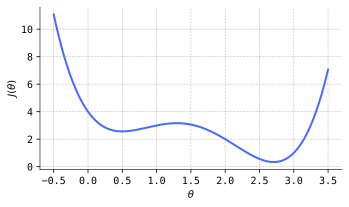

In [1]:
import torch
from torch.utils.data import DataLoader
from torch.distributions.multivariate_normal import MultivariateNormal
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib_inline.backend_inline
import sys
sys.path.append('/Users/johnmyers/code/stats-book-materials/notebooks')
from gd_utils import GD, SGD
plt.style.use('../aux-files/custom_style_light.mplstyle')
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
blue = '#486AFB'
magenta = '#FD46FC'

def J(theta):
    return (theta ** 4) - 6 * (theta ** 3) + 11 * (theta ** 2) - 7 * theta + 4

grid = torch.linspace(start=-0.5, end=3.5, steps=300)
plt.plot(grid, J(grid))
plt.xlabel('$\\theta$')
plt.ylabel('$J(\\theta)$')
plt.gcf().set_size_inches(w=5, h=3)
plt.tight_layout()

From the graph, we see that the objective function has minimums of approximately $J(0.5)$ and $J(2.7)$.

It will be convenient to introduce the following terminology for our optimization problems:

```{prf:definition}
:label: extrema-def

Let $J: \bbr^n \to \bbr$ be a function. A vector $\btheta^\star$ is a _local minimizer_ of $J(\btheta)$ provided that

$$
J(\btheta^\star) \leq J(\btheta)
$$

for all $\btheta$ in a neighborhood of $\btheta^\star$; if this inequality holds for _all_ $\btheta$, then $\btheta^\star$ is called a _global minimizer_ of $J(\btheta)$. If we flip the inequality the other direction, then we obtain the definitions of _local_ and _global maximizers_. Collectively, local and global minimizers and maximizers of $J(\btheta)$ are called _extremizers_, and the values $J(\btheta^\star)$ of the function where $\btheta^\star$ is an extremizer are called _extrema_ or _extreme values_. 
```

Using this terminology, we would say that $0.5$ is (approximately) a local minimizer of our polynomial objective function $J(\theta)$, while $2.7$ is (approximately) a global minimizer.

Let's see how the single-variable version of the _gradient descent algorithm_ would solve our optimization problem. This algorithm depends on an initial guess for a minimizer, as well as two parameters called the _learning rate_ and the _number of gradient steps_. We will state the algorithm first, and then walk through some intuition for why it works:

```{margin}

The loop runs from $t=0$ to $t=N-1$, inclusive. This convention is intended to match the implementation of `for` loops in Python for `t` ranging through the iterable `range(N)`. 
```

```{prf:algorithm} Single-variable gradient descent
:label: single-var-gd-alg

**Input:** A differentiable objective function $J:\mathbb{R}\to \mathbb{R}$, an initial guess $\theta_0\in \mathbb{R}$ for a local minimizer $\theta^\star$, a learning rate $\alpha>0$, and the number $N$ of gradient steps.

**Output:** An approximation to a local minimizer $\theta^\star$.

---

&nbsp;&nbsp; 1. $\theta := \theta_0$ <br>
&nbsp;&nbsp; 2. For $t$ from $0$ to $N-1$, do: <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3. $\theta := \theta - \alpha J'(\theta)$ <br>
&nbsp;&nbsp; 4. Return $\theta$
```

Though this simple description of the algorithm outputs just a single approximation to a local minimizer, in practice it is often convenient to output the entire sequence of $\theta$'s produced as the algorithm iterates through the `for` loop:

$$
\theta_0,\theta_1,\ldots,\theta_t,\ldots,\theta_{N}.
$$

Then, as we will see below, by tracking the associated objective values

$$
J(\theta_0), J(\theta_1),\ldots, J(\theta_t), \ldots, J(\theta_N),
$$

one may monitor convergence of the algorithm.

The assignment

$$
\theta := \theta - \alpha J'(\theta)
$$ (update-rule-eqn)

in the `for` loop is called the _update rule_. This form is convenient for implementation in code, but for theoretical analysis, it is often convenient to rewrite the rule as a _recurrence relation_ in the form

$$
\theta_{t+1} = \theta_{t} - \alpha J'(\theta_{t}),
$$

for all $t\geq 0$. We say that the new parameter $\theta_{t+1}$ is obtained by taking a _gradient step_ from $\theta_{t}$. The first update occurs when $t=0$, yielding

$$
\theta_1 = \theta_{0} - \alpha J'(\theta_{0}).
$$

To understand the intuition behind the algorithm, consider the two cases that the derivative $J'(\theta_0)$ is positive or negative:

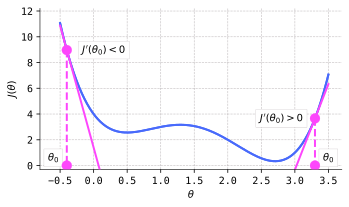

In [2]:
def J_prime(theta):
    return 4 * (theta ** 3) - 18 * (theta ** 2) + 22 * theta - 7

plt.plot(grid, J(grid), color=blue)
plt.plot(grid, J_prime(-0.4) * (grid + 0.4) + J(-0.4), color=magenta, zorder=10)
plt.scatter(-0.4, J(-0.4), color=magenta, s=100, zorder=15)
plt.scatter(-0.4, 0, color=magenta, s=100, zorder=20)
plt.plot([-0.4, -0.4], [J(-0.4), 0], color=magenta, linestyle='--')

plt.plot(grid, J(grid))
plt.plot(grid, J_prime(3.3) * (grid - 3.3) + J(3.3))
plt.scatter(3.3, J(3.3), color=magenta, s=100, zorder=10)
plt.scatter(3.3, 0, color=magenta, s=100, zorder=10)
plt.plot([3.3, 3.3], [J(3.3), 0], color=magenta, linestyle='--')

plt.text(-0.6, 0.6, '$\\theta_0$', ha='center', va='center', bbox=dict(facecolor='white', edgecolor=None))
plt.text(0.15, J(-0.4), "$J'(\\theta_0)<0$", ha='center', va='center', bbox=dict(facecolor='white', edgecolor=None))
plt.text(3.5, 0.6, '$\\theta_0$', ha='center', va='center', bbox=dict(facecolor='white', edgecolor=None))
plt.text(2.8, J(3.3), "$J'(\\theta_0)>0$", ha='center', va='center', bbox=dict(facecolor='white', edgecolor=None))

plt.xlim(-0.8, 3.7)
plt.ylim(-0.3, 12.2)
plt.xlabel('$\\theta$')
plt.ylabel('$J(\\theta)$')
plt.gcf().set_size_inches(w=5, h=3)
plt.tight_layout()

In this plot, we've drawn the tangent lines to the graph of $J(\theta)$ at two initial values $\theta_0=-0.4$ and $\theta_0=3.3$. Since the derivatives are the slopes of these tangent lines, the sign of the derivative is negative when $\theta_0=-0.4$ and positive when $\theta_0 = 3.3$. In the first case, we have

```{math}
:label: first-update-eqn

\theta_1 = -0.4 - \alpha J'(-0.4) > -0.4
```

since $\alpha>0$, while in the second case we have

```{math}
:label: second-update-eqn

\theta_1 = 3.3 - \alpha J'(3.3) < 3.3.
```

But notice that the nearest minimizer to $\theta_0 = -0.4$ is $\theta^\star \approx 0.5$, and so the new $\theta_1$ computed according to {eq}`first-update-eqn` should be closer to $\theta^\star$ than the initial guess $\theta_0$, provided that the (scaled) negative derivative

```{math}
:label: neg-derivative-eqn
-\alpha J'(\theta_0)
```

is not too large (in magnitude) causing the new $\theta_1$ to "overshoot" the minimizer $\theta^\star$. Similarly, the nearest minimizer to $\theta_0 = 3.3$ is $\theta^\star \approx 2.7$, so the new $\theta_1$ computed according to {eq}`second-update-eqn` should be closer to $\theta^\star$ than $\theta_0$, again provided that the (scaled) negative derivative {eq}`neg-derivative-eqn` is not too large in magnitude.

From these considerations, we conclude the following:

```{prf:observation}
:label: gd-obs

* The negative derivative $-J'(\theta)$ always "points downhill."
* When the gradient descent algorithm works, it locates a minimizer by following the negative derivative "downhill."
```

The sense in which the negative derivative "points downhill" is made precise by our observation that it is positive if the point $(\theta_0,J(\theta_0))$ sits on a decreasing portion of the graph of $J(\theta)$, and it is negative if $(\theta_0,J(\theta_0))$ is on an increasing portion of the graph. The role of the learning rate $\alpha$ is to scale down the magnitude of the negative derivative so that the gradient step in the update rule does not cause $\theta_1$ to "overshoot" a nearby minimizer.

Let's run the gradient algorithm four times, with various settings of the parameters:

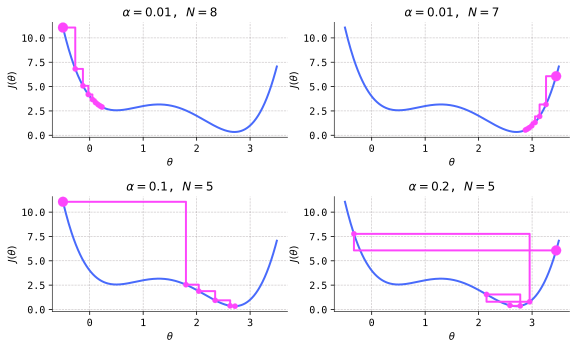

In [3]:
gd_parameters = {'theta0': [torch.tensor([-0.5]),
                            torch.tensor([3.45]),
                            torch.tensor([-0.5]),
                            torch.tensor([3.45])],
                 'num_steps': [8, 7, 5, 5],
                 'lr': [1e-2, 1e-2, 1e-1, 2e-1]}

_, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 5))
grid = torch.linspace(start=-0.5, end=3.5, steps=300)

for i, axis in enumerate(axes.flatten()):
    gd_parameters_slice = {key: value[i] for key, value in gd_parameters.items()}
    gd_output = GD(**gd_parameters_slice, J=J)
    
    alpha = gd_parameters_slice['lr']
    N = gd_parameters_slice['num_steps']
    
    axis.plot(grid, J(grid))
    axis.step(x=gd_output.thetas, y=gd_output.objectives, where='post', color=magenta, zorder=2)
    axis.scatter(x=gd_output.thetas, y=gd_output.objectives, s=30, color=magenta, zorder=2)
    axis.scatter(x=gd_output.thetas[0], y=gd_output.objectives[0], s=100, color=magenta, zorder=2)
    axis.set_xlabel('$\\theta$')
    axis.set_ylabel('$J(\\theta)$')
    axis.set_title(f'$\\alpha={alpha}$, $N={N}$')
plt.tight_layout()

In all four plots, the large magenta dot represents the initial point $(\theta_0,J(\theta_0))$, while the smaller dots represent the remaining $N$ points

$$
(\theta_1,J(\theta_1)), (\theta_2, J(\theta_2)),\ldots, (\theta_N,J(\theta_N)),
$$

where $N$ is the number of gradient steps. In the first row of the figure, the algorithm appears to be converging in both cases to the nearest minimizer to the initial guesses. In the second row, the learning rate is (relatively) large, causing the first gradient steps to "overshoot" the nearest minimizers to the initial guesses. However, the algorithm still appears to converge in both cases.

```{admonition} Problem Prompt

Do problem 1 on the worksheet.
```

It is possible for the gradient descent algorithm to diverge, especially if the learning rate is too large. For example, suppose that we set the learning rate to $\alpha = 0.2$ and use $\theta_0 = 3.5$ as our initial guess. Then three steps of gradient descent produce the following:

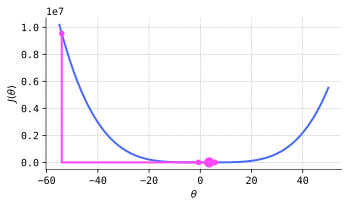

In [4]:
gd_output = GD(J=J,
               theta0=torch.tensor([3.5]),
               lr=2e-1,
               num_steps=3)

grid = torch.linspace(start=-55, end=50, steps=300)
plt.plot(grid, J(grid))
plt.step(x=gd_output.thetas, y=gd_output.objectives, where='post', color=magenta, zorder=2)
plt.scatter(x=gd_output.thetas, y=gd_output.objectives, s=30, color=magenta, zorder=2)
plt.scatter(x=gd_output.thetas[0], y=gd_output.objectives[0], s=100, color=magenta, zorder=2)

plt.xlabel('$\\theta$')
plt.ylabel('$J(\\theta)$')
plt.gcf().set_size_inches(w=5, h=3)
plt.tight_layout()

We see already that $J(\theta_3) \approx 10^7$; in fact, we have $J(\theta_t) \to \infty$ as $t\to\infty$ for these particular parameters.

```{admonition} Problem Prompt

Do problems 2 and 3 on the worksheet.
```

Of course, one can often prevent divergence by simply using a smaller learning rate, but sometimes a large _initial_ learning rate is desirable to help the algorithm quickly find the neighborhood of a minimizer. So, what we desire is a scheme to shrink the learning rate from large values to smaller ones as the algorithm runs. This scheme is called a _learning rate schedule_, and it is implemented by adding an extra _decay rate_ parameter to the gradient descent algorithm:

```{prf:algorithm} Single-variable gradient descent with learning rate decay
:label: single-variable-gd-alg

**Input:** A differentiable objective function $J:\mathbb{R}\to \mathbb{R}$, an initial guess $\theta_0\in \mathbb{R}$ for a local minimizer $\theta^\star$, a learning rate $\alpha>0$, a decay rate $\beta \in [0, 1)$, and the number $N$ of gradient steps.

**Output:** An approximation to a local minimizer $\theta^\star$.

---

&nbsp;&nbsp; 1. $\theta := \theta_0$ <br>
&nbsp;&nbsp; 2. For $t$ from $0$ to $N-1$, do: <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3. $\theta := \theta - \alpha (1-\beta)^{t+1} J'(\theta)$ <br>
&nbsp;&nbsp; 4. Return $\theta$
```

The new parameter $\beta$, called the _decay rate_, shrinks the learning rate as

$$
\alpha (1-\beta) > \alpha (1-\beta)^2 >\cdots > \alpha (1-\beta)^t > \cdots > \alpha (1-\beta)^N,
$$

provided that $\beta> 0$. Setting $\beta=0$ results in _no_ change in the learning rate. In our diverging example above, setting the decay rate to $\beta=0.1$ results in:

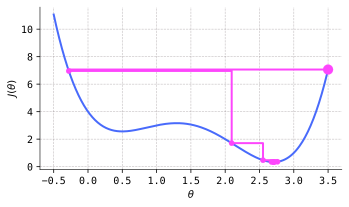

In [5]:
gd_output = GD(J=J,
               theta0=torch.tensor([3.5]),
               lr=2e-1,
               num_steps=8,
               decay_rate=0.1)

grid = torch.linspace(start=-0.5, end=3.5, steps=300)
plt.plot(grid, J(grid))
plt.step(x=gd_output.thetas, y=gd_output.objectives, where='post', color=magenta, zorder=2)
plt.scatter(x=gd_output.thetas, y=gd_output.objectives, s=30, color=magenta, zorder=2)
plt.scatter(x=gd_output.thetas[0], y=gd_output.objectives[0], s=100, color=magenta, zorder=2)

plt.xlabel('$\\theta$')
plt.ylabel('$J(\\theta)$')
plt.gcf().set_size_inches(w=5, h=3)
plt.tight_layout()

We have carried out $N=8$ gradient steps, and it appears that the algorithm has successfully located the minimizer $\theta^\star \approx 2.7$.

```{admonition} Problem Prompt

Do problem 4 on the worksheet.
```

The learning rate $\alpha$ and decay rate $\beta$ are often chosen by experimentation.

```{admonition} Tip

When using the gradient descent algorithm to solve an optimization problem, try beginning with a learning rate and decay rate of around $\alpha \approx 0.01$ and $\beta \approx 0.1$, respectively.
```

These values may be tuned by the analyst by closely monitoring the values of the objective function $J(\theta)$ as the algorithm runs. This is easy in the single-variable case, since one can plot the graph of $J(\theta)$. In the multi-variable case, however, the graph of $J(\theta)$ may live in many more dimensions than we can visualize, so the analyst might track the values of the objective function against the number of gradient steps. For example, with our polynomial objective function $J(\theta)$ from above and

$$
\theta_0 = -0.5, \quad \alpha = 0.01, \quad \beta = 0.1,
$$

we would plot the following:

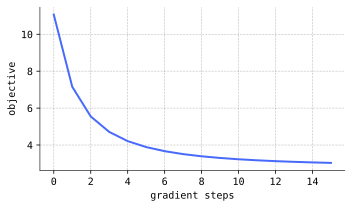

In [6]:
gd_output = GD(J=J,
               theta0=torch.tensor([-0.5]),
               lr=1e-2,
               num_steps=15,
               decay_rate=0.1)

plt.plot(range(len(gd_output.objectives)), gd_output.objectives)
plt.xlabel('gradient steps')
plt.ylabel('objective')
plt.gcf().set_size_inches(w=5, h=3)
plt.tight_layout()

One may use this plot to decide on the total number $N$ of gradient steps; simply choose $N$ large enough to reach a point where the plot "plateaus" or "levels out," indicating that the algorithm is converging on a minimizer. Alternatively, the analyst may build an automatic stopping condition into the algorithm that halts when the magnitude between successive objective values is less than some chosen threshold, say

$$
|J(\theta_t) - J(\theta_{t-1}) | < \epsilon,
$$

where $\epsilon>0$ is a small number.








(curvature-der-sec)=
## Curvature and derivatives in higher dimensions

If $\theta^\star$ is an extremizer of a differentiable function $J:\bbr \to \bbr$, then $\theta^\star$ must be a _stationary point_ in the sense that

$$
J'(\theta^\star)=0.
$$ (stationary-eqn)

The name arises from the observation that small (first-order infinitesimal) perturbations of $\theta^\star$ do not change the value $J(\theta^\star)$, i.e., the value $J(\theta^\star)$ remains _stationary_ under small perturbations. In certain very favorable situations, we may be able to solve the stationarity equation {eq}`stationary-eqn` for $\theta^\star$ to obtain a formula in closed form. In this case, the iterative gradient descent algorithm is not needed. But $\theta^\star$ being a solution to the stationarity equation {eq}`stationary-eqn` is only a _necessary_ condition for it to be an extremizer---sufficient conditions may be obtained by considering the _local curvature_ of the graph of $J$ near $\theta^\star$.

Our goal in this section is twofold: First, we briefly recall how these curvature considerations help us identify extremizers in the single-variable case---the relevant tools are the first and second derivatives. Then, we generalize these derivatives to higher dimensions to obtain _gradient vectors_ and _Hessian matrices_. We indicate how local curvature in higher dimensions may be computed using these new tools and, in particular, how we may use them to identify extremizers.

So, let's begin with the familiar routine from single-variable calculus called the _Second Derivative Test_. Given a point $\theta^\star$ and a twice-differentiable function $J:\bbr \to \bbr$, the test splits into two cases:

1. If $J'(\theta^\star) = 0$ and $J''(\theta^\star) > 0$, then $\theta^\star$ is a local minimizer.
2. If $J'(\theta^\star) = 0$ and $J''(\theta^\star) < 0$, then $\theta^\star$ is a local maximizer.

Provided that the second derivative of $J$ not only exists but is also _continuous_, then intuition for the Second Derivative Test may be explained via local curvature. Indeed, in the first case, positivity of the second derivative means that the graph of $J$ is _convex_ near $\theta^\star$, while in the second case negativity of the second derivative means that the graph is _concave_. The nature of the curvature helps us distinguish between minimizers and maximizers:

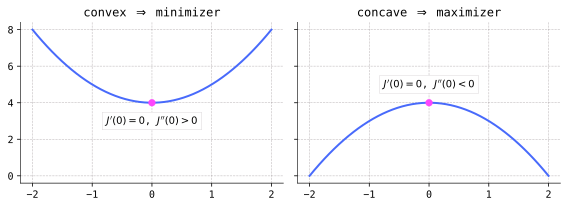

In [7]:
def f(x):
    return x ** 2 + 4

def g(x):
    return -x ** 2 + 4

functions = [f, g]
grid = np.linspace(-2, 2)
_, axes = plt.subplots(ncols=2, figsize=(8, 3), sharey=True, sharex=True)

for i, (function, axis) in enumerate(zip(functions, axes)):
    axis.plot(grid, function(grid))
    axis.scatter(0, 4, s=50, color=magenta, zorder=3)
    if i == 0:
        axis.text(0, 3, "$J '(0) = 0$, $J''(0)>0$", ha='center', va='center', bbox=dict(facecolor='white', edgecolor=None))
        axis.set_title('convex $\Rightarrow$ minimizer')
    else:
        axis.text(0, 5, "$J '(0) = 0$, $J ''(0)<0$", ha='center', va='center', bbox=dict(facecolor='white', edgecolor=None))
        axis.set_title('concave $\Rightarrow$ maximizer')

plt.tight_layout()

To see _why_ second derivatives encode local curvature, let's suppose $J''(\theta^\star) >0$ at some point $\theta^\star$. Then continuity of $J''$ means that there is a number $\epsilon>0$ such that $J''(\theta)>0$ for all $\theta$ in the open interval $I = (\theta^\star - \epsilon, \theta^\star + \epsilon)$ centered at $\theta^\star$. But the second derivative is the first derivative of the first derivative, and thus positivity of $J''$ over $I$ means that $J'$ is increasing over $I$. Since the first derivative $J'$ measures the slope of the graph of $J$, this must mean that the slopes increase as we move from left to right across $I$. Thus, $J$ is convex near $\theta^\star$.

We already met the notion of _concavity_ back in {numref}`kl-div-sec` where it was fundamental in our proof of Gibb's inequality in {prf:ref}`gibbs-thm`. As shown in the figure above, a function is _concave_ if it lies below its secant lines, while it is _convex_ if it lies above. Both these shapes have implications for the search for extremizers---in particular, stationary points of concave and convex functions are _always_ global extremizers. The proof of this claim, along with equivalent characterizations of concavity and convexity in terms of tangent lines and tangent (hyper)planes are given in the two main theorems in the [appendix](app-conv-sec). (The claims are easily believable, while the proofs are annoyingly fussy. At least glance at the statements of the theorems to convince yourself that your intuition is on point, but do not feel compelled to go through the proofs line by line.)

How might we generalize the Second Derivative Test to higher dimensions? To help gain insight into the answer, let's first add only one additional dimension, going from a function of a single variable to a twice-differentiable function of two variables:

$$
J:\bbr^2 \to \bbr, \quad \btheta \mapsto J(\btheta).
$$

Actually, to obtain the best results relating curvature to second derivatives, we shall assume that the second-order partial derivatives are _continuous_, though this isn't strictly needed for some definitions and results below. Functions with continuous first- and second-order partial derivatives are said to be of _class $C^2$_ in the mathematical literature.

For example, let's suppose that the graph of $J$ is an upside down paraboloid:

```{image} ../img/paraboloid-plot.png
:width: 75%
:align: center
```
&nbsp;

At any given point on this surface (like the one above the black dot) there is not a _single_ slope and curvature, but rather _infinitely many_ slopes and curvatures in all the different directions that one may step in the plane $\bbr^2$. These different directions may be represented as _directional vectors_ in the plane; here are three examples:

```{image} ../img/directional-plot.png
:width: 75%
:align: center
```
&nbsp;

Taking advantage of the very special circumstance that our graph is embedded as a surface in $\bbr^3$, we may visualize the slopes and curvatures in these three directions by first intersecting the graph with three vertical planes:

```{image} ../img/sectional-plot.png
:width: 75%
:align: center
```
&nbsp;

```{margin}

This figure and discussion might be slightly misleading, for in dimensions $\geq 3$, the curves on the surface that we are after are _not_ obtained as intersections with hyperplanes. This figure very much relies on the fact that our graph is embedded in $\bbr^3$.
```

The intersections of these vertical planes and the surface yield curves called _sections_---for the planes displayed in the plot above, the sections are a trio of downward opening parabolas. The slopes and curvatures on the surface in the three directions are then the slopes and curvatures of these sectional curves.

To obtain these slopes and curvatures, let's suppose that $\bv$ is one of the three directional vectors in the plane, with its tail hooked to the point $\btheta$ represented by the black dot. As we let $t\in \bbr$ vary, the vector sum

$$
t \bv + \btheta
$$

traces out the line in the plane $\bbr^2$ through $\btheta$ and in the direction of $\bv$. It follows that the mapping

$$
t\mapsto J(t\bv + \btheta)
$$

is exactly the sectional curve on the surface. Notice that this mapping is a real-valued function of a single real variable $t$, and thus it has first and second derivatives in the ordinary sense from single-variable calculus. These considerations motivate the following definition, which applies to functions of $n$ variables (not just two).

```{margin}

We are _not_ requiring directional vectors to have unit length!
```

```{prf:definition}
:label: directional-der-def

Let $J : \bbr^n \to \bbr$ be a function of class $C^2$, $\btheta\in \bbr^n$ a point, and $\bv \in \bbr^n$ a vector. We define the *directional first derivative of $J$ at $\btheta$ in the direction $\bv$* to be

$$
J_\bv'(\btheta) \def \frac{\text{d}}{\text{d}t} \bigg|_{t=0} J(t\bv + \btheta),
$$

while we define the _directional second derivative_ to be

$$
J_\bv''(\btheta) \def \frac{\text{d}^2}{\text{d}t^2} \bigg|_{t=0} J(t\bv + \btheta).
$$

In this context, the vector $\bv$ is called the _directional vector_.
```

```{admonition} Problem Prompt

Do problem 5 on the worksheet.
```

The familiar relations between these directional derivatives and partial derivatives pass through the gadgets defined in the following box. The first is familiar to us from our course in multi-variable calculus:

```{margin}

The notation "$\nabla^2$" is also sometimes used for the [Laplace](https://en.wikipedia.org/wiki/Laplace_operator#) operator!
```

```{prf:definition}
:label: grad-vec-def

Let $J : \bbr^n \to \bbr$ be a function of class $C^2$ and $\btheta\in \bbr^n$ a point. We define the _gradient vector_ to be

$$
\nabla J(\btheta) \def \begin{bmatrix} \displaystyle \frac{\partial J}{\partial \theta_i}(\btheta) \end{bmatrix} =
\begin{bmatrix}
\displaystyle\frac{\partial J}{\partial \theta_1}(\btheta) \\
\vdots \\
\displaystyle \frac{\partial J}{\partial \theta_n}(\btheta)
\end{bmatrix} \in \bbr^n,
$$

while we define the the _Hessian matrix_ to be

$$
\nabla^2 J(\btheta) \def \begin{bmatrix} \displaystyle \frac{\partial^2 J}{\partial \theta_i \partial \theta_j}(\btheta) \end{bmatrix}
= \begin{bmatrix}
\displaystyle\frac{\partial^2 J}{\partial \theta_1^2}(\btheta) & \cdots &\displaystyle \frac{\partial^2 J}{\partial \theta_1 \partial \theta_n}(\btheta) \\
\vdots & \ddots & \vdots \\
\displaystyle\frac{\partial^2 J}{\partial \theta_n \partial \theta_1} (\btheta) & \cdots & \displaystyle\frac{\partial^2 J}{\partial \theta_n^2}(\btheta)
\end{bmatrix} \in \bbr^{n\times n}.
$$
```

Note that since $J$ is of class $C^2$, the Hessian matrix is symmetric.

The following important theorem expresses the relations between the first and second directional derivatives and the gradient vector and Hessian matrix.

```{prf:theorem} Slopes, curvatures, and partial derivatives
:label: directional-der-grad-thm

Let $J:\bbr^n \to \bbr$ be a function of class $C^2$, $\btheta \in \bbr^n$ a point, and $\bv \in \bbr^n$ a directional vector.

1. We have
    
    $$
    J_{\bv}'(\btheta) = \bv^\intercal \nabla J(\btheta).
    $$

2. We have
    
    $$
    J_{\bv}''(\btheta) = \bv^\intercal \big(\nabla^2 J(\btheta)\big) \bv.
    $$

```

So, the directional first derivative is obtained through an inner product with the gradient vector, while the directional second derivative is the quadratic form induced by the Hessian matrix.

```{prf:proof}
The proofs are simple exercises using the multi-variable Chain Rule. Indeed, note that

$$
\frac{\text{d}}{\text{d}t} J(t \bv + \btheta) = \sum_{i=1}^n v_i \frac{\partial J}{\partial \theta_i} (t\bv + \btheta).
$$

Plugging in $t=0$ to both sides of this last equality then yields (1.). On the other hand, differentiating both sides of the equation with respect to $t$ (and using the Chain Rule a second time) gives

$$
\frac{\text{d}^2}{\text{d}t^2} J(t \bv + \btheta) = \sum_{i=1}^n v_i \frac{\text{d}}{\text{d}t}\frac{\partial J}{\partial \theta_i} (t\bv + \btheta)  = \sum_{i,j=1}^n v_i v_j \frac{\partial^2 J}{\partial \theta_i \partial \theta_j}(t\bv + \btheta).
$$

Plugging in $t=0$ to both ends yields (2.). Q.E.D.
```

```{admonition} Problem Prompt

Do problem 6 on the worksheet.
```


```{margin}

Notice that the value of $J''_\bv(\btheta)$ is the same if $\bv$ is replaced with $-\bv$, by {prf:ref}`directional-der-grad-thm`. Thus, the local curvature at $\btheta$ only depends on the _line_ indicated by $\bv$, not the direction that it points.
```



When the directional vector $\bv$ is a _unit_ vector, the value of the directional first derivative $J'_\bv(\btheta)$ is interpreted as the (instantaneous) rate of change of $J$ at $\btheta$ in the direction indicated by $\bv$. Likewise, if $\bv$ is unit vector, then the value of the directional second derivative $J''_\bv(\btheta)$ is interpreted as the local curvature of $J$ at $\btheta$ through the line indicated by $\bv$.

For our purposes, the most important properties of the gradient vector $\nabla J(\btheta)$ are (1) that it points in the direction of _maximum_ rate of change, (2) its negative points in the direction of _minimum_ rate of change, and (3) it is orthogonal to the _level surfaces_ of $J$, otherwise called _contours_. By definition, such a surface is the $(n-1)$-dimensional set of solutions $\btheta\in \bbr^n$ to an equation

$$
J(\btheta) = c
$$

for fixed $c\in \bbr$. In the case that $n=2$, these level surfaces are actually _level curves_; for our upside down paraboloid above, they are the blue ellipses in the following:

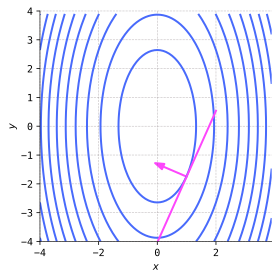

In [8]:
def f(x, y):
    return -4 * x ** 2 - y ** 2 + 15

grid = np.linspace(0, 2)
x, y = np.mgrid[-4:4:0.1, -4:4:0.1]
z = f(x, y)

def tangent_line(x):
    return (8 / 3.5) * (x - 1) - 1.75

plt.contour(x, y, z, levels=10, colors=blue, linestyles='solid')
plt.plot(grid, tangent_line(grid), color=magenta)
plt.arrow(1, -1.75, -8 / 10, 3.5 / 10, head_width=0.2, head_length=0.3, fc=magenta, ec=magenta, linewidth=2)
plt.gcf().set_size_inches(4, 4)
plt.ylim(-4, 4)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.tight_layout()

The vector in the figure is the gradient vector, and the magenta line is the tangent line to the contour that passes through the point at the tail of the gradient. Note that the gradient is orthogonal to this tangent line, and therefore also orthogonal to the contour.

In general, it should be intuitively clear from the equation

$$
J_{\bv}'(\btheta) = \bv^\intercal J(\btheta)
$$

in {prf:ref}`directional-der-grad-thm` that the gradient is orthogonal to level surfaces. Indeed, if $\bv$ is a tangent vector to the level surface passing through $\btheta$, then $J$ should _not_ change (at least up to first order) as we step in the direction of $\bv$ since (by definition) the function $J$ is constant along its level surfaces. Thus, we have $J_\bv'(\btheta)=0$, and so $\bv^\intercal \nabla J(\btheta) =0$. This shows the gradient vector is indeed orthogonal to the level surface passing through $\btheta$. (For a more rigorous argument, see the proposition on page 23 of {cite}`GP2010`.)

Let's return to the first two properties of the gradient vector mentioned above, that it points in the direction of maximum rate of change and its negative points in the direction of minimum rate of change. In informal treatments, these claims are often justified by an appeal to the "angle" $\phi\in [0,\pi]$ between two vectors $\bu$ and $\bv$, which allegedly fits into an equation

$$
\bv^\intercal \bu = |\bu||\bv| \cos{\phi}.
$$ (geom-dot-eq)

Taking $\bu = \nabla J(\btheta)$ and supposing $\bv$ has unit length, we get

$$
J_\bv'(\btheta) = \bv^\intercal \nabla J(\btheta) = |\nabla J(\btheta) | \cos{\phi}
$$

from {prf:ref}`directional-der-grad-thm`. Since $\cos{\phi}$ is maximized and minimized over $[0,\pi]$ when $\phi=0$ and $\phi=\pi$, respectively, it then follows that the gradient points in the direction of maximum rate of change, while its negative points in the direction of minimum rate of change. However, this argument does not address what is meant by the "angle" $\phi$ between the vectors---certainly in two and three dimensions we have some idea of what this angle might be, but what about in 1000 dimensions?

But the "angle" $\phi$ is just a distraction. It is much cleaner logically to work directly with the [Cauchy-Schwarz inequality](https://en.wikipedia.org/wiki/Cauchy%E2%80%93Schwarz_inequality), which is the true reason that the gradient has these extremizing properties. An immediate corollary of this inequality says that an innner product of one vector against a unit vector is maximized (minimized) when the unit vector points in the same (opposite) direction as the first vector. In the following, we give a proof of the extremizing properties of the gradient vector using the Cauchy-Schwarz inequality, and then show afterwards how it may be used to give a rigorous definition of the angle $\phi$.

```{prf:theorem} Properties of gradient vectors
:label: grad-uphill-thm

Let $J:\bbr^n \to \bbr$ be a function of class $C^2$, $\btheta \in \bbr^n$ a point, and suppose the gradient vector $\nabla J(\btheta)$ is nonzero.

1. The gradient vector $\nabla J(\btheta)$ points in the direction of maximum rate of change.

2. The negative gradient vector $-\nabla J(\btheta)$ points in the direction of minimum rate of change.

3. The gradient vector $\nabla J(\btheta)$ is orthogonal to level surfaces.

```

```{prf:proof}

We already offered a "proof" of the third statement above, so we need only prove the first two. For this, we recall that for any two vectors $\bu$ and $\bv$, the Cauchy-Schwarz inequality states that

$$
|\bu^\intercal \bv| \leq |\bu | |\bv|,
$$ (cs-ineq-eq)

with equality if and only if $\bu$ and $\bv$ are parallel (i.e., one is a scalar multiple of the other). In particular, if we take $\bu = \nabla J(\btheta)$, let $\bv$ be a unit vector, and use {prf:ref}`directional-der-grad-thm`, we get

$$
-|\nabla J(\btheta )| \leq J_\bv'(\btheta) = \bv^ \intercal \nabla J(\btheta) \leq |\nabla J(\btheta )|.
$$

The goal is then to identify unit vectors $\bv$ that extremize the derivative $J_\bv'(\btheta)$ in these bounds.

But if the derivative achieves the upper bound, then by the criterion for equality in the Cauchy-Schwarz inequality {eq}`cs-ineq-eq`, there must be a nonzero scalar $\alpha$ such that

$$
\bv = \alpha \nabla J(\btheta).
$$

But then

$$
\alpha |\nabla J(\btheta)|^2 = \bv^\intercal \nabla J(\btheta) = |\nabla J(\btheta)|,
$$

and so $\alpha = 1/ |\nabla J(\btheta)|$. Hence, the derivative $J_\bv'(\btheta)$ achieves its maximum value exactly when $\bv$ is the normalized gradient vector. It is just as easy to show that the derivative achieves its minimum value when $\bv$ is the negative of the normalized gradient vector. Q.E.D.
```

```{admonition} Problem Prompt

Do problem 7 on the worksheet.
```

Now, let's return to the "angle" $\phi$ between two nonzero vectors $\bu$ and $\bv$ in $\bbr^n$. From the Cauchy-Schwarz inequality {eq}`cs-ineq-eq`, it follows that

$$
-1 \leq \frac{\bv^\intercal \bu}{|\bu||\bv|} \leq 1.
$$

We then _define_ the _angle_ $\phi$ between the two vectors to be the unique number $\phi \in [0,\pi]$ such that

$$
\cos{\phi} = \frac{\bv^\intercal \bu}{|\bu||\bv|}.
$$

Thus, the fact that the angle $\phi$ even _exists_ is a consequence of the Cauchy-Schwarz inequality.

Observe that the part in {prf:ref}`grad-uphill-thm` about the negative gradient vector "pointing downhill" is the higher-dimensional version of the observation in {prf:ref}`gd-obs` regarding the negative derivative of a single-variable function. This property will be key to the general multi-variable gradient descent algorithm that we will discuss in {numref}`multivariate-grad-desc-sec` below.

Let's now turn toward extremizers of a multi-variable function $J:\bbr^n \to \bbr$ of class $C^2$ in arbitrary dimension $n$. As you may recall from multi-variable calculus, the stationarity equation

$$
\nabla(J(\btheta^\star)) = 0
$$

is a _necessary_ condition for $\btheta^\star$ to be an extremizer of $J$. As in the single-variable case, one might hope to classify stationary points (i.e., solutions $\btheta^\star$ to the stationarity equation) as minimizers and maximizers based on the local curvature of $J$. For if $J$ is convex (concave) in _all_ directions at $\btheta^\star$, then intuition suggests that $\btheta^\star$ should be a local minimizer (maximizer). But from {prf:ref}`directional-der-grad-thm`, the local directional curvatures at $\btheta^\star$ are measured by the quadratic form

$$
\bv^\intercal \big( \nabla^2 J(\btheta^\star) \big) \bv
$$

as $\bv$ cycles through all nonzero vectors in $\bbr^n$. Thus, if these numbers are _always_ positive (negative), then we would expect the stationary point $\btheta^\star$ is a local minimizer (maximizer). However, to say that these numbers are either always positive or negative means exactly that the Hessian matrix is positive definite or negative definite, in the language of {prf:ref}`first-semidefinite-def`. So, the question becomes: If we know that the Hessian matrix is positive (negative) definite at a stationary point $\btheta^\star$, is $\btheta^\star$ necessarily a local minimizer (maximizer)?

The answer is _yes_!

```{prf:theorem} Second Derivative Test
:label: second-der-test-thm

Let $J:\bbr^n \to \bbr$ be a function of class $C^2$ and $\btheta^\star \in \bbr^n$ a stationary point.

1. If the Hessian matrix $\nabla^2 J(\btheta^\star)$ is positive definite, then $\btheta^\star$ is a local minimizer.
1. If the Hessian matrix $\nabla^2 J(\btheta^\star)$ is negative definite, then $\btheta^\star$ is a local maximizer.
```

For a proof of this result, see Theorem 13.10 in {cite}`Apostol1974`. Note also that if the Hessian matrix is either positive semidefinite or negative semidefinite _everywhere_, then every stationary point is a global extremizer; see {prf:ref}`main-convex-multi-thm` in the appendix.

```{admonition} Problem Prompt

Do problem 8 on the worksheet.
```

With infinitely many local (directional) curvatures at a point on the graph of a function $J:\bbr^n\to \bbr$, it will be convenient to obtain a single number that attempts to summarize the complexity of the local curvature. The first step toward obtaining such a summary is given in the following:

```{margin}

Remember, as we saw in {prf:ref}`psd-char-thm`, the eigenvalues of a positive definite matrix are all real and positive. Hence the linear ordering {eq}`ordering-eqn`. The existence of the orthonormal basis of eigenvectors is guaranteed by the Spectral Theorem (see the proof of {prf:ref}`psd-char-thm`).
```

```{prf:theorem} Eigenvalues, eigenvectors, and local curvature
:label: max-min-curve-thm

Let $J:\bbr^n \to \bbr$ be a function of class $C^2$ and $\btheta \in \bbr^n$ a point with positive definite Hessian matrix $\nabla^2 J(\btheta)$. Suppose we linearly order the eigenvalues of the Hessian matrix as

$$
0 < \lambda_1 \leq \lambda_2 \leq \cdots \leq \lambda_n.
$$ (ordering-eqn)

Then:

1. The directional curvature $J''_\bv(\btheta)$ is maximized exactly when $\bv$ lies in the eigenspace of $\lambda_n$, in which case $J''_\bv(\btheta) = \lambda_n$.

2. The directional curvature $J''_\bv(\btheta)$ is minimized exactly when $\bv$ lies in the eigenspace of $\lambda_1$, in which case $J''_\bv(\btheta) = \lambda_1$.
```

```{prf:proof}

Let $\be_1,\ldots,\be_n$ be the associated orthonormal basis of eigenvectors with

$$
\nabla^2 J(\btheta) \be_i = \lambda_i\be_i
$$

for each $i$. Given a unit vector $\bv$, there are unique scalars $\alpha_1,\ldots,\alpha_n$ such that

$$
\bv = \alpha_1 \be_1 + \cdots + \alpha_n \be_n
$$

and

$$
\alpha_1^2 + \cdots + \alpha_n^2 =1.
$$ (sum-to-one-eqn)

But then

$$
J''_\bv(\btheta) = \bv^\intercal \big(\nabla^2 J(\btheta) \big) \bv = \sum_{i,j=1}^n \alpha_i\alpha_j \be_i^\intercal \big(\nabla^2 J(\btheta) \big) \be_j = \sum_{i,j=1}^n \alpha_i\alpha_j\lambda_j \be_i^\intercal \be_j = \sum_{i=1}^n \alpha_i^2 \lambda_i,
$$

where the first equality follows from {prf:ref}`directional-der-grad-thm`. Using {eq}`sum-to-one-eqn`, eliminate $\alpha_n^2$ from the last sum in favor of the other $\alpha$'s to get

$$
J''_\bv(\btheta) = \sum_{i=1}^{n-1}(\lambda_i - \lambda_n)\alpha_i^2 + \lambda_n.
$$

Letting $m$ be the smallest integer such that

$$
\lambda_{m-1} < \lambda_m = \lambda_{m+1} = \cdots = \lambda _n,
$$

we have

$$
J''_\bv(\btheta) = \sum_{i=1}^{m-1}(\lambda_i - \lambda_n)\alpha_i^2 + \lambda_n.
$$

(If $m=1$, then we interpret this expression as $J''_\bv(\btheta) = \lambda_n$.) But $\lambda_i -\lambda_n < 0$ for each $i=1,\ldots,m-1$, and so $J''_\bv(\btheta)$ is clearly maximized when

$$
\alpha_1 = \cdots = \alpha_{m-1} = 0,
$$

which implies that $\bv$ lies in the eigenspace of $\lambda_n$. This establishes the claim in the first statement, and the one in the second follows from the same type of argument with the obvious changes. Q.E.D.
```

```{admonition} Problem Prompt

Do problem 9 on the worksheet.
```


If the Hessian matrix is positive definite, then its extreme eigenvalues are exactly the extreme local (directional) curvatures. The ratio of the largest curvature to the smallest should then convey the "variance" or the "range" of these curvatures. This ratio has a name:

```{prf:definition}
:label: condition-num-def

Let $\bA$ be an $n\times n$ square matrix with eigenvalues $\lambda_1,\ldots,\lambda_n$.

1. The _spectral radius_ of $\bA$, denoted $\rho(\bA)$, is given by

    $$
    \rho(\bA) \def \max_{i=1,\ldots,n} |\lambda_i|.
    $$

2. If $\bA$ is positive definite, the _condition number_ of $\bA$, denoted $\kappa(\bA)$, is the ratio

    $$
    \kappa(\bA) \def \frac{\lambda_\text{max}}{\lambda_\text{min}}
    $$

    of the largest eigenvalue of $\bA$ to the smallest. Note that since all eigenvalues of $\bA$ are positive, $\lambda_\text{max}$ is exactly the spectral radius $\rho(\bA)$.
```

This definition of _condition number_ applies only in the case that $\bA$ is positive definite and hence all its eigenvalues are positive. In the general case, the definition needs to be altered; see [here](https://en.wikipedia.org/wiki/Condition_number#Matrices), for example.

```{admonition} Problem Prompt

Do problem 10 on the worksheet.
```

Intuitively, when the condition number of a positive definite Hessian matrix is large (in which case the Hessian matrix is called _ill-conditioned_), the curvatures vary widely as we look in all different directions; conversely, when the condition number is near $1$, the directional curvatures are all nearly the same. As we will see in the next section, ill-conditioned Hessian matrices inflate an important upper-bound on the speed of convergence of gradient descent. In other words, ill-conditioned Hessian matrices _may_ signal slow convergence of gradient descent.














(multivariate-grad-desc-sec)=
## Gradient descent in multiple variables

With the gradient vector taking the place of the derivative, it is easy to generalize the single-variable gradient descent algorithm from {prf:ref}`single-variable-gd-alg` to multiple variables:


```{prf:algorithm} Multi-variable gradient descent with learning rate decay
:label: gd-alg

**Input:** A differentiable function $J:\mathbb{R}^n\to \mathbb{R}$, an initial guess $\btheta_0\in \mathbb{R}^n$ for a local minimizer $\btheta^\star$, a learning rate $\alpha>0$, a decay rate $\beta \in [0, 1)$, and the number $N$ of gradient steps.

**Output:** An approximation to a local minimizer $\btheta^\star$.

---

&nbsp;&nbsp; 1. $\btheta := \btheta_0$ <br>
&nbsp;&nbsp; 2. For $t$ from $0$ to $N-1$, do: <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3. $\btheta := \btheta - \alpha(1-\beta)^{t+1} \nabla J(\btheta)$ <br>
&nbsp;&nbsp; 4. Return $\btheta$.
```

Just like the single-variable version, in practice it is convenient to track the entire sequence of $\btheta$'s produced by the algorithm:

$$
\btheta_0,\btheta_1, \ldots,\btheta_t,\ldots,\btheta_N.
$$

For an example, let's consider the polynomial objective function

$$
J:\bbr^2 \to \bbr, \quad J(\btheta) = J(\theta_1,\theta_2) = (\theta_1^2 + 10 \theta_2^2)\big((\theta_1-1)^2 + 10(\theta_2-1)^2 \big)
$$ (two-dim-poly-eq)

in two dimensions. Its graph looks like

```{image} ../img/objective-plot.png
:width: 75%
:align: center
```
&nbsp;

while its contour plot is

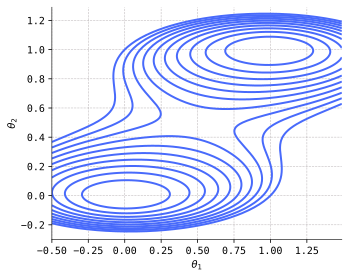

In [9]:
def J(theta):
   theta1 = theta[0]
   theta2 = theta[1]
   return (theta1 ** 2 + 10 * theta2 ** 2) * ((theta1 - 1) ** 2 + 10 * (theta2 - 1) ** 2)

x, y = np.mgrid[-0.50:1.5:0.01, -0.3:1.3:0.01]
grid = np.dstack((x, y))
z = np.apply_along_axis(J, axis=-1, arr=grid)

plt.contour(x, y, z, levels=range(11), colors=blue)
plt.xlabel('$\\theta_1$')
plt.ylabel('$\\theta_2$')
plt.gcf().set_size_inches(w=5, h=4)
plt.tight_layout()

The function has two minimizers at

$$
\btheta^\star = (0, 0), (1,1),
$$

as well as a "saddle point" at $(0.5, 0.5)$ where the gradient $\nabla J(\btheta)$ vanishes. Let's run the gradient descent algorithm four times, beginning with _no_ learning rate decay, and track the approximations $\btheta_t$ in $\mathbb{R}^2$ plotted over the contours of $J(\btheta)$:

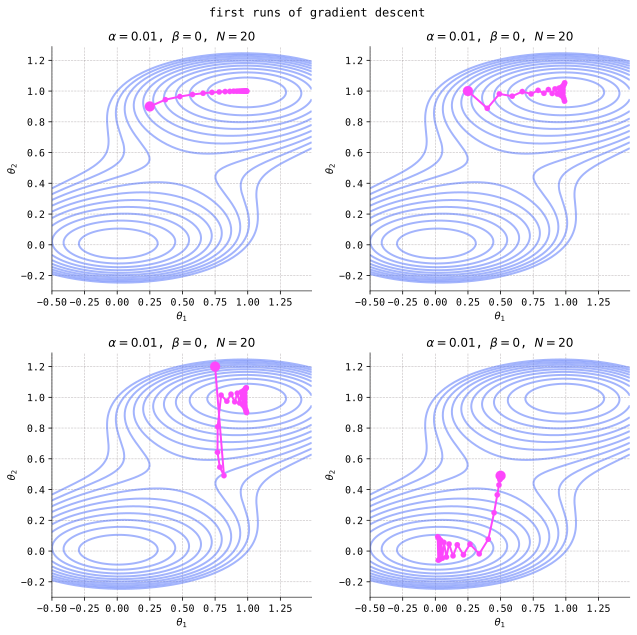

In [10]:
gd_parameters = {'theta0': [torch.tensor([0.25, 0.9]),
                            torch.tensor([0.25, 1]),
                            torch.tensor([0.75, 1.2]),
                            torch.tensor([0.5, 0.49])]}
alpha = 1e-2
beta = 0
N = 20

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))

for i, axis in enumerate(axes.flatten()):
    gd_parameters_slice = {key: value[i] for key, value in gd_parameters.items()}
    gd_output = GD(J=J,
                   lr=alpha,
                   num_steps=N,
                   decay_rate=beta,
                   **gd_parameters_slice)
        
    axis.contour(x, y, z, levels=range(11), colors=blue, alpha=0.5)
    axis.plot(gd_output.thetas[:, 0], gd_output.thetas[:, 1], color=magenta)
    axis.scatter(gd_output.thetas[:, 0], gd_output.thetas[:, 1], s=30, color=magenta, zorder=2)
    axis.scatter(x=gd_output.thetas[0, 0], y=gd_output.thetas[0, 1], s=100, color=magenta, zorder=2)
    
    axis.set_xlabel('$\\theta_1$')
    axis.set_ylabel('$\\theta_2$')
    axis.set_title(f'$\\alpha={alpha}$, $\\beta={beta}$, $N={N}$')
fig.suptitle('first runs of gradient descent')
plt.tight_layout()

The large magenta dots in the plots indicate the initial guesses $\btheta_0$, while the smaller dots indicate the approximations $\btheta_t$ for $t>0$. The algorithm _appears_ to be converging nicely to the minimizer $\btheta^\star = (1,1)$ in the upper-left plot, while in the other three plots, the algorithm finds a neighborhood of a minimizer, but then oscillates back and forth and never appears to settle down. This is due jointly to the elliptical (non-circular) shape of the contours and poorly chosen learning rates.

Let's carry the runs out further, to $N=125$ gradient steps, and plot the objective values versus gradient steps:

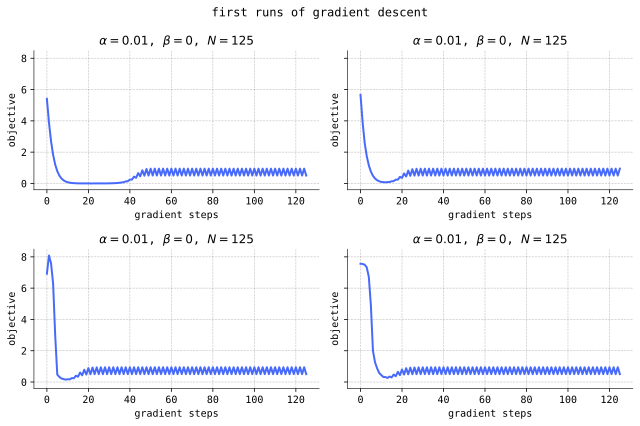

In [11]:
gd_parameters = {'theta0': [torch.tensor([0.25, 0.9]),
                            torch.tensor([0.25, 1]),
                            torch.tensor([0.75, 1.2]),
                            torch.tensor([0.5, 0.49])]}
alpha = 1e-2
beta = 0
N = 125

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 6), sharey=True)

for i, axis in enumerate(axes.flatten()):
    gd_parameters_slice = {key: value[i] for key, value in gd_parameters.items()}
    gd_output = GD(J=J,
                   lr=alpha,
                   num_steps=N,
                   decay_rate=beta,
                   **gd_parameters_slice)
    
    axis.plot(range(len(gd_output.objectives)), gd_output.objectives)
    
    axis.set_xlabel('gradient steps')
    axis.set_ylabel('objective')
    axis.set_title(f'$\\alpha={alpha}$, $\\beta={beta}$, $N={N}$')
fig.suptitle('first runs of gradient descent')
plt.tight_layout()

The oscillatory nature of the runs is even more clear. In particular, we now see that even the first run, which _appeared_ to be converging, begins to oscillate after about 40 gradient steps. Let's take a closer look at the trace of this first run, and also plot the components $\theta_1$ and $\theta_2$ versus gradient steps:

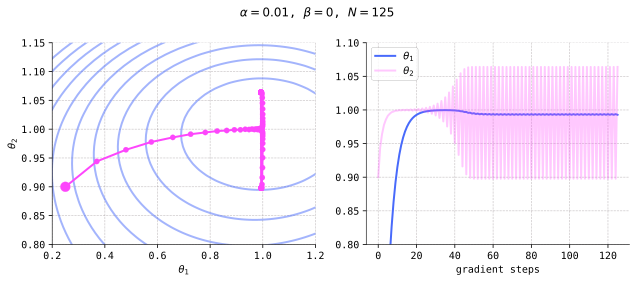

In [12]:
theta0 = torch.tensor([0.25, 0.9])
alpha = 1e-2
beta = 0
N = 125
gd_output = GD(J=J, theta0=theta0, lr=alpha, num_steps=N, decay_rate=beta)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

axes[0].contour(x, y, z, levels=range(11), colors=blue, alpha=0.5)
axes[0].plot(gd_output.thetas[:, 0], gd_output.thetas[:, 1], color=magenta)
axes[0].scatter(gd_output.thetas[:, 0], gd_output.thetas[:, 1], s=30, color=magenta, zorder=2)
axes[0].scatter(x=gd_output.thetas[0, 0], y=gd_output.thetas[0, 1], s=100, color=magenta, zorder=2)
axes[0].set_xlabel('$\\theta_1$')
axes[0].set_ylabel('$\\theta_2$')
axes[0].set_xlim(0.2, 1.2)
axes[0].set_ylim(0.8, 1.15)

axes[1].plot(range(len(gd_output.objectives)), gd_output.thetas[:, 0], label='$\\theta_1$')
axes[1].plot(range(len(gd_output.objectives)), gd_output.thetas[:, 1], alpha=0.3, label='$\\theta_2$')
axes[1].set_xlabel('gradient steps')
axes[1].set_ylim(0.8, 1.1)
axes[1].legend()

fig.suptitle(f'$\\alpha={alpha}$, $\\beta={beta}$, $N={N}$')
plt.tight_layout()

Both plots make clear that the oscillations occur mostly along the semi-minor axes of the elliptical contours, which coincides with the direction of largest curvature. From the previous section, we know that local curvatures are encoded in the Hessian matrix. This suggests that studying the Hessian matrix might lead to insights into the convergence properties of gradient descent. But first, to prepare for this general study, let's do:

```{admonition} Problem Prompt

Do problem 11 on the worksheet.
```

To begin the theoretical study of convergence of gradient descent, let's start more generally with any function $J:\bbr^2 \to \bbr$ of class $C^2$ and $\btheta^\star$ a point. We then take a degree-$2$ Taylor polynomial approximation centered at $\btheta^\star$:

$$
J(\btheta) \approx J(\btheta^\star) + (\btheta - \btheta^\star)^\intercal \nabla J(\btheta^\star) + \frac{1}{2} (\btheta - \btheta^\star)^\intercal \big(\nabla^2 J(\btheta^\star) \big) (\btheta - \btheta^\star).
$$

If we believe that the Taylor polynomial accurately reflects the local geometry of the graph of $J$ near $\btheta^\star$ to within whatever degree of approximation we require, then we may as well replace $J$ with its Taylor polynomial, and thereby assume that $J$ is a degree-$2$ (inhomogeneous) polynomial:

$$
J(\btheta) = \frac{1}{2}\btheta^\intercal \bH \btheta + \bb^\intercal \btheta + c,
$$

where $\bH \in \bbr^{n\times n}$ is a symmetric matrix, $\bb\in \bbr^n$ is a vector, and $c\in \bbr$ is a scalar. As you may easily compute (see the [homework](https://github.com/jmyers7/stats-book-materials/blob/main/homework/11-homework.md#problem-2-derivatives-of-quadratic-functions)), the gradient vector and Hessian matrix are given by

$$
\nabla J(\btheta) = \bH \btheta + \bb \quad \text{and} \quad  \nabla^2 J(\btheta) = \bH.
$$

Assuming that the decay rate is $\beta=0$ while the learning rate $\alpha$ is arbitrary, the update rule in the algorithm is given by

$$
\btheta_{t+1} = \btheta_t - \alpha(\bH\btheta_t + \bb),
$$

for all $t\geq 0$. If $\btheta^\star$ is a stationary point (like a local minimizer), we may rewrite the update rule as

$$
\btheta_{t+1} - \btheta^\star = (\bI - \alpha \bH)(\btheta_t - \btheta^\star),
$$

which leads us to the closed form

$$
\btheta_t - \btheta^\star = (\bI - \alpha \bH)^t (\btheta_0 - \btheta^\star),
$$ (gd-closed-eqn)

for all $t\geq 1$.

Now, let's suppose that $\btheta^\star$ is a local minimizer of $J$ with positive definite Hessian matrix $\bH$. We are in $2$-dimensions, so $\bH$ has only two eigenvalues:

$$
0 < \lambda_1 \leq \lambda_2.
$$

Then the eigenvalues of the matrix $\bI - \alpha \bH$ are $1 - \alpha \lambda_1$ and $1-\alpha \lambda_2$, and they may be linearly ordered as

$$
1 - \alpha \lambda_2 \leq 1 - \alpha \lambda_1.
$$ (both-evecs-eq)

The eigenvectors $\be_1,\be_2$ of $\bI - \alpha\bH$ are the same as those of $\bH$ (which may be chosen to form an orthonormal basis of $\bbr^2$), so if we have

$$
\btheta_0 - \btheta^\star = \gamma_1 \be_1 + \gamma_2 \be_2
$$

for some scalars $\gamma_1,\gamma_2\in \bbr$, then from {eq}`gd-closed-eqn` we get

$$
\btheta_t - \btheta^\star = \gamma_1 (1-\alpha \lambda_1)^t \be_1 + \gamma_2 (1-\alpha \lambda_2)^t \be_2
$$ (evec-gd-eq)

for all $t\geq 1$.

For the particular run of the algorithm shown in the last plot, we have

$$
\be_1^\intercal = (1,0), \quad \be_2^\intercal = (0,1), \quad \alpha = 0.01, \quad \lambda_1 = 22, \quad \lambda_2 = 220,
$$

so that {eq}`evec-gd-eq` is

$$
\btheta_t - \btheta^\star = \gamma_1 (0.78)^t \be_1 + \gamma_2 (-1.2)^t \be_2.
$$

Since $|0.78|< 1$ while $|-1.2| >1$, this last equation shows why the algorithm diverges along the direction $\be_2$ of maximum curvature, while converging along the direction $\be_1$ of minimum curvature. The trick, then, is to choose the learning rate $\alpha$ so that both eigenvalues in {eq}`both-evecs-eq` have magnitude less than $1$.

To do this, we apply the triangle inequality to the right-hand side of {eq}`evec-gd-eq` to obtain the upper bound

$$
|\btheta_t - \btheta^\star| \leq \rho\left(\bI - \alpha \bH\right)^t |\btheta_0 - \btheta^\star |,
$$ (op-norm-eq)

for all $t\geq 1$, where

$$
\rho\left(\bI - \alpha \bH\right) = \max \{ |1-\alpha \lambda_1|, |1-\alpha \lambda_2|\}
$$

is the spectral radius of the matrix $\bI - \alpha \bH$. To guarantee fastest convergence, we want to choose the learning rate $\alpha$ that minimizes the spectral radius. But an easy computation shows that this optimal learning rate is given by

$$
\alpha = \frac{2}{\lambda_1 + \lambda_2},
$$

in which case we get

$$
\rho\left( \bI - \alpha \bH \right) = |1-\alpha \lambda_1| = |1-\alpha \lambda_2|.
$$

Then, with this choice of $\alpha$, we have

$$
|\btheta_t - \btheta^\star| \leq \rho\left(1 - \alpha \lambda_1\right)^t |\btheta_0 - \btheta^\star | = \left( 1 - \frac{2}{1 + \kappa(\bH)} \right)^t |\btheta_0 - \btheta^\star |,
$$ (conv-bound-eq)

where $\kappa(\bH)$ is the condition number of the Hessian matrix $\bH$.

This shows that the fastest rates of convergence guaranteed by our arguments are obtained for those objective functions that have Hessian matrices at local minimizers with condition numbers near $1$. In the extreme case that $\kappa(\bH)=1$, notice that the bound shows $\btheta_1 = \btheta^\star$, i.e., the algorithm lands on the local minimizer $\btheta^\star$ in just one gradient step. The inequality {eq}`conv-bound-eq` is tight, by which we mean that there are worst-case initial guesses $\btheta_0$ for which equality holds. This is the case, for example, if the difference $\btheta_0 - \btheta^\star$ is equal to the eigenvector corresponding to $\lambda_1$.

This argument easily adapts to the case that the objective function $J:\bbr^n \to \bbr$ is defined on a Euclidean space of arbitrary dimension. We present the general result in a theorem:

```{prf:theorem} Quadratic approximations and convergence rates
:label: quadratic-conv-thm

Let $J:\bbr^n \to \bbr$ be a function of class $C^2$ and $\btheta^\star$ a local minimizer with positive definite Hessian matrix $\bH = \nabla^2 J(\btheta^\star)$. For initial guesses $\btheta_0$ sufficiently near $\btheta^\star$ to allow a degree-$2$ Taylor polynomial approximation, the gradient descent algorithm with learning rate

$$
\alpha = \frac{2}{\lambda_\text{min} + \lambda_\text{max}} \quad \text{and} \quad \beta=0
$$

converges to $\btheta^\star$ exponentially fast, with

$$
|\btheta_t - \btheta^\star| \leq \left( 1 - \frac{2}{1 + \kappa(\bH)} \right)^t |\btheta_0 - \btheta^\star |
$$

for each $t\geq 1$. Here, $\kappa(\bH)$ is the condition number of $\bH$.
```

The ratio $2/(1 + \kappa(\bH))$ is sometimes called the _rate of convergence_. Of course, in order to obtain the exponentially quick convergence guaranteed by the theorem, one needs to place their initial guess $\btheta_0$ "sufficiently close" to the minimizer. But this would require the analyst to already have some sense of where the minimizer is likely to be located! This restricts its usefulness in practice.

For our polynomial objective $J$ given in {eq}`two-dim-poly-eq` above, we compute the spectra of the Hessian matrices at the minimizers $(0,0)$ and $(1,1)$ to be $\{22,220\}$ in both cases. Thus, if we choose learning rate $\alpha = 2/(22+220) \approx 0.008$ and re-run the gradient descent algorithm with the same initial guesses to test {prf:ref}`quadratic-conv-thm`, we get the new plots:

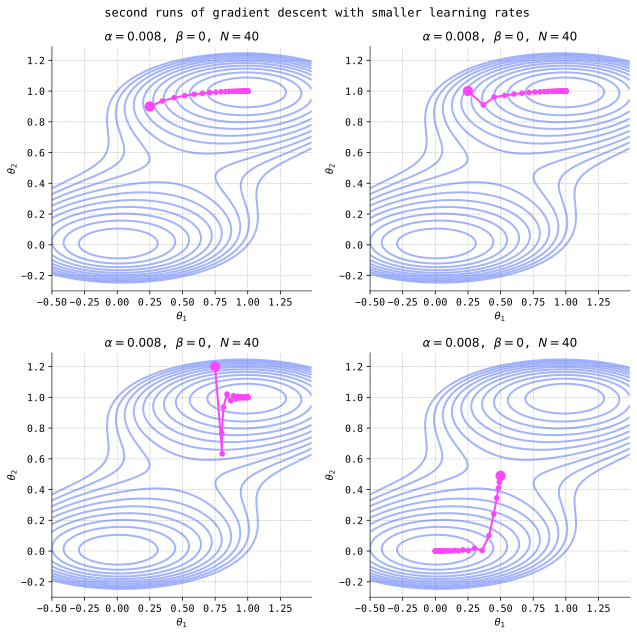

In [13]:
gd_parameters = {'theta0': [torch.tensor([0.25, 0.9]),
                            torch.tensor([0.25, 1]),
                            torch.tensor([0.75, 1.2]),
                            torch.tensor([0.5, 0.49])]}
alpha = 8e-3
beta = 0
N = 40

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))

for i, axis in enumerate(axes.flatten()):
    gd_parameters_slice = {key: value[i] for key, value in gd_parameters.items()}
    gd_output = GD(J=J,
                   lr=alpha,
                   num_steps=N,
                   decay_rate=beta,
                   **gd_parameters_slice)
    
    axis.contour(x, y, z, levels=range(11), colors=blue, alpha=0.5)
    axis.plot(gd_output.thetas[:, 0], gd_output.thetas[:, 1], color=magenta)
    axis.scatter(gd_output.thetas[:, 0], gd_output.thetas[:, 1], s=30, color=magenta, zorder=2)
    axis.scatter(x=gd_output.thetas[0, 0], y=gd_output.thetas[0, 1], s=100, color=magenta, zorder=2)
    
    axis.set_xlabel('$\\theta_1$')
    axis.set_ylabel('$\\theta_2$')
    axis.set_title(f'$\\alpha={alpha}$, $\\beta={beta}$, $N={N}$')
fig.suptitle('second runs of gradient descent with smaller learning rates')
plt.tight_layout()

Just like magic, the undesirable oscillations have vanished. We take a closer look at the third run of the algorithm, in the bottom left of the figure:

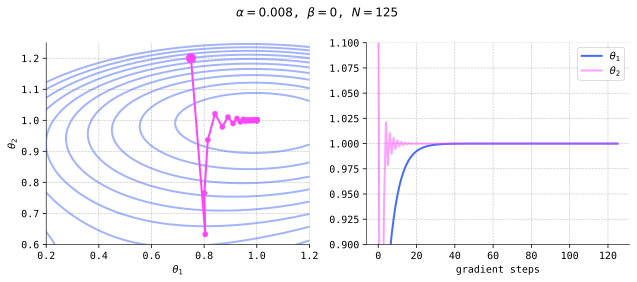

In [14]:
theta0 = torch.tensor([0.75, 1.2])
alpha = 8e-3
beta = 0
N = 125
gd_output = GD(J=J, theta0=theta0, lr=alpha, num_steps=N, decay_rate=beta)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

axes[0].contour(x, y, z, levels=range(11), colors=blue, alpha=0.5)
axes[0].plot(gd_output.thetas[:, 0], gd_output.thetas[:, 1], color=magenta)
axes[0].scatter(gd_output.thetas[:, 0], gd_output.thetas[:, 1], s=30, color=magenta, zorder=2)
axes[0].scatter(x=gd_output.thetas[0, 0], y=gd_output.thetas[0, 1], s=100, color=magenta, zorder=2)
axes[0].set_xlabel('$\\theta_1$')
axes[0].set_ylabel('$\\theta_2$')
axes[0].set_xlim(0.2, 1.2)
axes[0].set_ylim(0.6, 1.25)

axes[1].plot(range(len(gd_output.objectives)), gd_output.thetas[:, 0], label='$\\theta_1$')
axes[1].plot(range(len(gd_output.objectives)), gd_output.thetas[:, 1], alpha=0.5, label='$\\theta_2$')
axes[1].set_xlabel('gradient steps')
axes[1].set_ylim(0.9, 1.1)
axes[1].legend()

fig.suptitle(f'$\\alpha={alpha}$, $\\beta={beta}$, $N={N}$')
plt.tight_layout()

We may also dampen the oscillations and keep the original (relatively large) learning rates by adding a slight learning rate decay at $\beta = 0.05$:

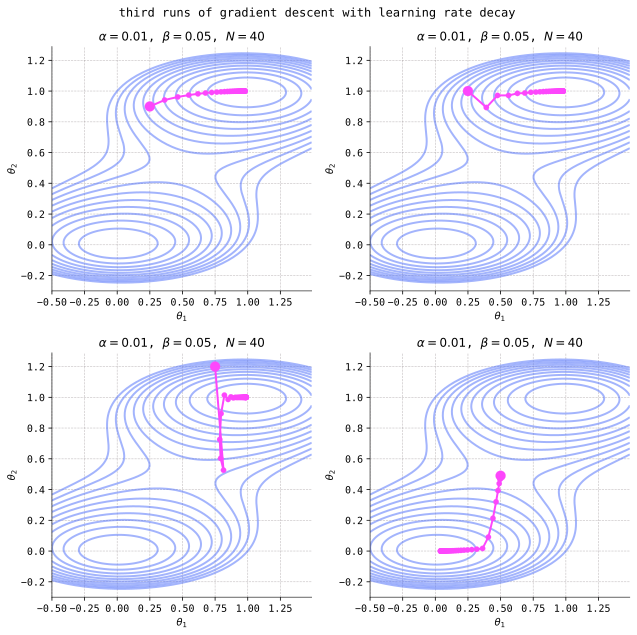

In [15]:
gd_parameters = {'theta0': [torch.tensor([0.25, 0.9]),
                            torch.tensor([0.25, 1]),
                            torch.tensor([0.75, 1.2]),
                            torch.tensor([0.5, 0.49])]}
alpha = 1e-2
N = 40
beta = 0.05

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))

for i, axis in enumerate(axes.flatten()):
    gd_parameters_slice = {key: value[i] for key, value in gd_parameters.items()}
    gd_output = GD(J=J,
                   lr=alpha,
                   num_steps=N,
                   decay_rate=beta,
                   **gd_parameters_slice)

    axis.contour(x, y, z, levels=range(11), colors=blue, alpha=0.5)
    axis.plot(gd_output.thetas[:, 0], gd_output.thetas[:, 1], color=magenta)
    axis.scatter(gd_output.thetas[:, 0], gd_output.thetas[:, 1], s=30, color=magenta, zorder=2)
    axis.scatter(x=gd_output.thetas[0, 0], y=gd_output.thetas[0, 1], s=100, color=magenta, zorder=2)
    
    axis.set_xlabel('$\\theta_1$')
    axis.set_ylabel('$\\theta_2$')
    axis.set_title(f'$\\alpha={alpha}$, $\\beta={beta}$, $N={N}$')
fig.suptitle('third runs of gradient descent with learning rate decay')
plt.tight_layout()

Here are the values of the objective function for these last runs with learning rate decay, plotted against the number of gradient steps:

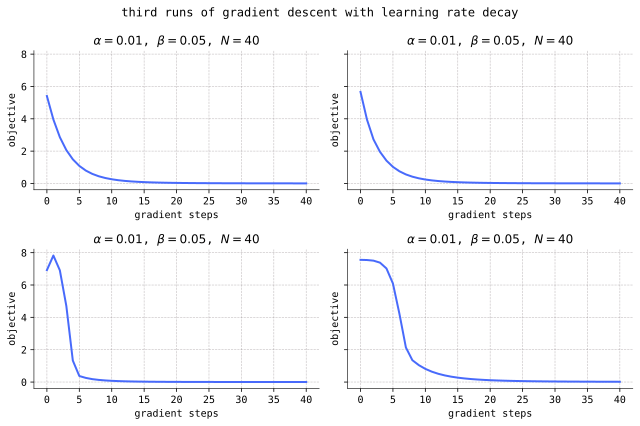

In [16]:
gd_parameters = {'theta0': [torch.tensor([0.25, 0.9]),
                            torch.tensor([0.25, 1]),
                            torch.tensor([0.75, 1.2]),
                            torch.tensor([0.5, 0.49])]}
alpha = 1e-2
N = 40
beta = 0.05

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 6), sharey=True)

for i, axis in enumerate(axes.flatten()):
    gd_parameters_slice = {key: value[i] for key, value in gd_parameters.items()}
    gd_output = GD(J=J,
                   lr=alpha,
                   num_steps=N,
                   decay_rate=beta,
                   **gd_parameters_slice)
    
    axis.plot(range(len(gd_output.objectives)), gd_output.objectives)
    
    axis.set_xlabel('gradient steps')
    axis.set_ylabel('objective')
    axis.set_title(f'$\\alpha={alpha}$, $\\beta={beta}$, $N={N}$')
fig.suptitle('third runs of gradient descent with learning rate decay')
plt.tight_layout()

Notice the initial "overshoot" in the plot in the bottom left, causing the objective function $J(\btheta)$ to _increase_ after the first gradient step. Recall also that the initial value $\btheta_0$ in the bottom right plot is near the saddle point $(0.5,0.5)$, causing $\nabla J(\btheta_0) \approx 0$. This accounts for the small initial changes in the objective function $J(\btheta)$ indicated by the (nearly) horizontal stretch early in the run of the algorithm.

Of course, an objective function $J:\mathbb{R}^2 \to \mathbb{R}$ defined on a $2$-dimensional input space is still not a realistic example of the objective functions encountered in the real world. In two dimensions, we have the ability to trace the algorithm's progress through $\mathbb{R}^2$ on contour plots, as we did multiple times above. In higher dimensions we lose this valuable visual aid. But no matter the input dimension, we may always plot the objective values against the number of gradient steps as a diagnostic plot for convergence.











(sgd-sec)=
## Stochastic gradient descent

Many of the objective functions that we will see in {numref}`Chapter %s <learning>` have a special form making them amenable to optimization via a variation of the gradient descent algorithm called _stochastic gradient descent_. These special objective functions are called _stochastic objective functions_, which look like

```{math}
:label: stoch-obj-eqn

J(\btheta) = E_{\bx \sim p(\bx)}\big[ g(\bx;\btheta) \big] = \sum_{\mathbf{x}\in \mathbb{R}^n} g(\mathbf{x};\btheta)p(\mathbf{x}),
```

where $p(\bx)$ is a probability mass function, $\btheta \in \mathbb{R}^k$ is a _parameter vector_, and $g:\mathbb{R}^{n+k} \to \mathbb{R}$ is a differentiable function. Very often, the mass function will be an empirical mass function of an observed multivariate dataset

$$
\bx_1,\bx_2,\ldots,\bx_m \in \mathbb{R}^n,
$$

so that

$$
J(\btheta) = \frac{1}{m} \sum_{i=1}^m g \big(\bx_i; \btheta \big).
$$

By linearity of the gradient operation, we have

$$
\nabla_\btheta J(\btheta) = \frac{1}{m} \sum_{i=1}^m \nabla_\btheta g\big(\bx_i; \btheta \big)
$$ (batch-eqn)

where we write $\nabla_\btheta$ to emphasize that the gradient is computed with respect to the parameter vector $\btheta$. In this context, the gradient descent algorithm applied to the objective function {eq}`batch-eqn` is given a new name:

```{prf:definition}
:label: batch-gd-def

The _batch gradient descent algorithm_ is the gradient descent algorithm applied to a stochastic objective function of the form {eq}`batch-eqn`.
```

Let's take a look at a simple example. Suppose that we define

```{math}
:label: quadratic-eqn

g: \bbr^4 \to \bbr, \quad g(\bx;\btheta) = \frac{1}{2}|\bx - \btheta|^2,
```

where $\bx,\btheta\in \bbr^2$. We create a bivariate dataset by drawing a random sample of size $1{,}024$ from a $\mathcal{N}_2(\boldsymbol0,I)$ distribution. A scatter plot of the dataset looks like this:

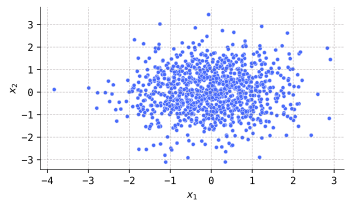

In [17]:
torch.manual_seed(42)
X = MultivariateNormal(loc=torch.zeros(2), covariance_matrix=torch.eye(2)).sample(sample_shape=(1024,))

sns.scatterplot(x=X[:, 0], y=X[:, 1])
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.gcf().set_size_inches(w=5, h=3)
plt.tight_layout()

Before running the algorithm, let's do:

```{admonition} Problem Prompt

Do problem 12 on the worksheet.
```

Now, two runs of the batch gradient descent algorithm produce the following plots of the objective function versus gradient steps:

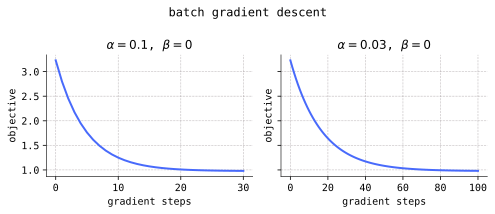

In [18]:
def g(X, theta):
    x1 = X[:, 0]
    x2 = X[:, 1]
    theta1 = theta[0]
    theta2 = theta[1]
    return 0.5 * ((x1 - theta1) ** 2 + (x2 - theta2) ** 2)

def J(theta):
    return g(X, theta).mean()

gd_parameters = {'num_steps': [30, 100],
                 'lr': [1e-1, 3e-2]}
beta = 0
theta0 = torch.tensor([1.5, 1.5])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 3), sharey=True)

for i, axis in enumerate(axes):
    gd_parameters_slice = {key: value[i] for key, value in gd_parameters.items()}
    gd_output = GD(**gd_parameters_slice, J=J, decay_rate=beta, theta0=theta0)
    
    alpha = gd_parameters_slice['lr']
    
    axis.plot(range(len(gd_output.objectives)), gd_output.objectives)
    
    axis.set_xlabel('gradient steps')
    axis.set_ylabel('objective')
    axis.set_title(f'$\\alpha={alpha}$, $\\beta={beta}$')
fig.suptitle('batch gradient descent')
plt.tight_layout()

If we track the parameters $\btheta = (\theta_1,\theta_2)$ during the runs, we get the following:

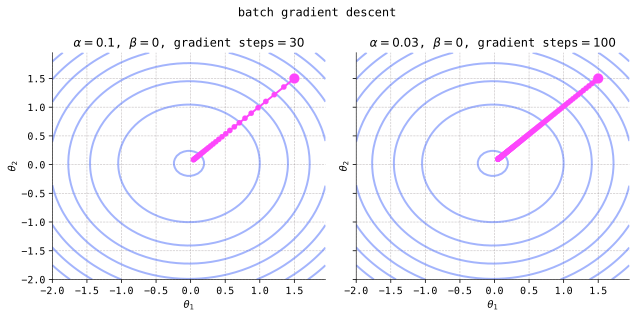

In [19]:
x, y = np.mgrid[-2:2:0.05, -2:2:0.05]
grid = np.dstack((x, y))
z = np.apply_along_axis(J, axis=-1, arr=grid)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4.5), sharey=True)

for i, axis in enumerate(axes):
    gd_parameters_slice = {key: value[i] for key, value in gd_parameters.items()}
    gd_output = GD(**gd_parameters_slice, J=J, decay_rate=beta, theta0=theta0)
    
    alpha = gd_parameters_slice['lr']
    N = gd_parameters_slice['num_steps']
    
    axis.contour(x, y, z, colors=blue, alpha=0.5, levels=np.arange(0, 10, 0.5))
    axis.plot(gd_output.thetas[:, 0], gd_output.thetas[:, 1], color=magenta)
    axis.scatter(gd_output.thetas[:, 0], gd_output.thetas[:, 1], s=30, color=magenta, zorder=2)
    axis.scatter(gd_output.thetas[0, 0], gd_output.thetas[0, 1], s=100, color=magenta, zorder=2)
    
    axis.set_title(f'$\\alpha={alpha}$, $\\beta={beta}$, gradient steps$={N}$')
    axis.set_xlabel('$\\theta_1$')
    axis.set_ylabel('$\\theta_2$')
fig.suptitle('batch gradient descent')
plt.tight_layout()

In both cases, notice that the algorithm is nicely converging toward the minimizer at $\btheta^\star \approx (0,0)$.

One of the drawbacks of the batch algorithm is that it needs the _entire_ dataset in order to take just a single gradient step. This isn't an issue for our small toy dataset of size $m=1{,}024$, but for the large datasets that you may encounter in the real world, this can be a serious hindrance to fast convergence.

One method for dealing with this bottleneck is to use _mini-batches_ of the data to compute gradient steps. To do so, we begin by randomly partitioning the dataset into subsets $B_1,B_2,\ldots,B_p$ called _mini-batches_:

```{math}
:label: mini-batch-eqn

B_1 \cup B_2 \cup \cdots \cup B_p = \{\bx_1,\bx_2,\ldots,\bx_m\}.
```

We would then expect from {eq}`batch-eqn` that

$$
\nabla J(\btheta) \approx \frac{1}{|B_j|} \sum_{\bx \in B_j} \nabla_\btheta g\big(\bx; \btheta\big),
$$ (mini-batch-grad-eqn)

for each $j=1,2,\ldots,p$, where $|B_j|$ is the cardinality (or size) of the $j$-th mini-batch. Very often, the mini-batch sizes are chosen to be equal to a common value $k$, except (possibly) for one to compensate for the fact that $m$ may not be evenly divisible by $k$. For example, if $m=100$ and $k=30$, then we would have four mini-batches, three of size $30$ and the fourth of size $10$.

The mini-batch version of the gradient descent algorithm loops over the mini-batches {eq}`mini-batch-eqn` and computes gradient steps using the approximation in {eq}`mini-batch-grad-eqn`. A single loop through _all_ the mini-batches, covering the _entire_ dataset, is called an _epoch_. This new version of the algorithm takes the number of epochs $N$ as a parameter.

```{prf:algorithm} Stochastic gradient descent with learning rate decay
:label: sgd-alg

**Input:** A dataset $\bx_1,\bx_2\ldots,\bx_m\in \mathbb{R}^n$, a differentiable function $g:\bbr^{n+k} \to \bbr$, an initial guess $\btheta_0\in \mathbb{R}^k$ for a minimizer $\btheta^\star$ of the stochastic objective function {eq}`batch-eqn`, a learning rate $\alpha>0$, a decay rate $\beta \in [0, 1)$, and the number $N$ of epochs.

**Output:** An approximation to a minimizer $\btheta^\star$.

---

&nbsp;&nbsp; 1. $\btheta := \btheta_0$ <br>
&nbsp;&nbsp; 2. $s := 0$ <br>
&nbsp;&nbsp; 3. For $t$ from $0$ to $N-1$, do: <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 4. Randomly partition the dataset into mini-batches $B_1,B_2,\ldots,B_p$ <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 5. For each mini-batch $B_j$, do: <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 6. $\btheta := \btheta - \displaystyle \alpha(1-\beta)^{s+1} \frac{1}{|B_j|} \sum_{\bx \in B_j} \nabla_\btheta g\big(\bx; \btheta\big)$ <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 7. $s := s+1$ <br>
&nbsp;&nbsp; 8. Return $\btheta$
```

Notice the auxiliary variable $s$, which counts the number of gradient steps and is used to decay the learning rate. As we mentioned above, very often the mini-batches are chosen to be of equal size $k$, except (possibly) for one mini-batch to compensate for the fact that $m$ may not be divisible by $k$. In this case, we pass in the mini-batch size $k$ as an additional parameter.

As in the versions of gradient descent explored above, in practice is convenient to code the algorithm so that it returns the entire sequence of $\btheta$'s produced to help monitor convergence. If there are $p$ mini-batches and $N$ epochs, then the output of the algorithm may be partitioned like this:

$$
\begin{array}{c|c}
\text{epoch number} & \text{output} \\ \hline
0 & \btheta_0 \\
1 & \btheta_1, \btheta_2,\ldots, \btheta_p \\
2 & \btheta_{p+1}, \btheta_{p+2},\ldots, \btheta_{2p} \\
\vdots & \vdots \\
N & \btheta_{(N-1)p+1}, \btheta_{(N-1)p+2},\ldots, \btheta_{Np}
\end{array}
$$

This leads to the following sequences of objective values:

$$
\begin{array}{c|c}
\text{epoch number} & \text{objectives} \\ \hline
0 & J(\btheta_0) \\
1 & J(\btheta_1), J(\btheta_2),\ldots, J(\btheta_p) \\
2 & J(\btheta_{p+1}), J(\btheta_{p+2}),\ldots, J(\btheta_{2p}) \\
\vdots & \vdots \\
N & J(\btheta_{(N-1)p+1}), J(\btheta_{(N-1)p+2}),\ldots, J(\btheta_{Np})
\end{array}
$$

In order to monitor convergence, we may plot the per-step objective values versus the gradient steps, as we have done in the previous two sections. But, depending on the mini-batch size, these plots may be quite noisy, so sometimes to get a better sense of the trend it is convenient to also track the _mean_ objective values per epoch. We will see examples below.

But first, we note that it is possible to select a mini-batch size of $k=1$, so that the algorithm computes a gradient step per data point. (Some references refer to _this_ algorithm as _stochastic gradient descent_.) In our example {eq}`quadratic-eqn` from above, a batch size of $k=1$ yields the following plots of objective values versus gradient steps:

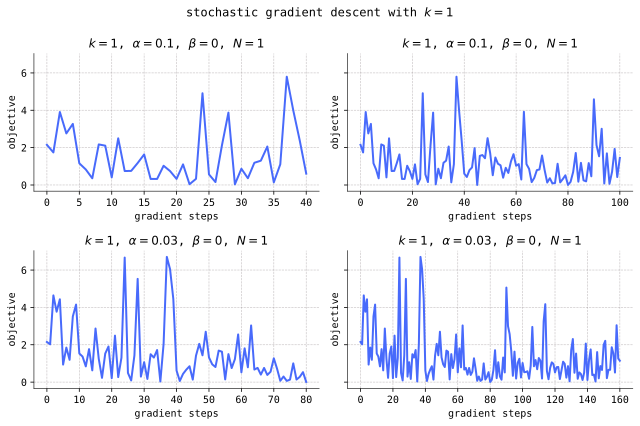

In [20]:
gd_parameters = {'lr': [1e-1, 1e-1, 3e-2, 3e-2],
                 'max_steps': [40, 100, 80, 160]}
beta = 0
theta0 = torch.tensor([1.5, 1.5])
k = 1
N = 1

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 6), sharey=True)

for i, axis in enumerate(axes.flatten()):
    gd_parameters_slice = {key: value[i] for key, value in gd_parameters.items()}
    sgd_output = SGD(**gd_parameters_slice,
                    g=g,
                    X=X,
                    theta0=theta0,
                    batch_size=k,
                    decay_rate=beta,
                    num_epochs=N,
                    random_state=42)
    
    alpha = gd_parameters_slice['lr']
    
    axis.plot(range(len(sgd_output.per_step_objectives)), sgd_output.per_step_objectives)
    axis.set_xlabel('gradient steps')
    axis.set_ylabel('objective')
    axis.set_title(f'$k={k}$, $\\alpha={alpha}$, $\\beta={beta}$, $N={N}$')
fig.suptitle(f'stochastic gradient descent with $k=1$')
plt.tight_layout()

Note that we have halted the runs early, before the algorithm has had a chance to make it through even one epoch. The plots are very noisy, though a slight downward trend in objective values is detectable. The trace of the algorithm through parameter space is shown in:

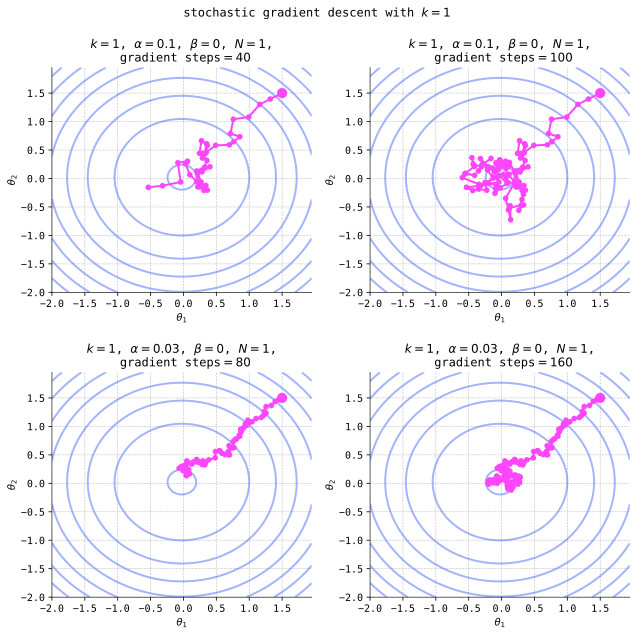

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))

for i, axis in enumerate(axes.flatten()):
    gd_parameters_slice = {key: value[i] for key, value in gd_parameters.items()}
    sgd_output = SGD(**gd_parameters_slice,
                    g=g,
                    X=X,
                    theta0=theta0,
                    batch_size=k,
                    decay_rate=beta,
                    num_epochs=N,
                    random_state=42)
    
    alpha = gd_parameters_slice['lr']
    max_steps = gd_parameters_slice['max_steps']
    
    axis.contour(x, y, z, levels=np.arange(0, 10, 0.5), colors=blue, alpha=0.5)
    axis.plot(sgd_output.thetas[:, 0], sgd_output.thetas[:, 1], color=magenta)
    axis.scatter(sgd_output.thetas[:, 0], sgd_output.thetas[:, 1], s=30, color=magenta, zorder=2)
    axis.scatter(sgd_output.thetas[0, 0], sgd_output.thetas[0, 1], s=100, color=magenta, zorder=2)
    
    axis.set_title(f'$k={k}$, $\\alpha={alpha}$, $\\beta={beta}$, $N={N}$,\n gradient steps$={max_steps}$')
    axis.set_xlabel('$\\theta_1$')
    axis.set_ylabel('$\\theta_2$')
fig.suptitle(f'stochastic gradient descent with $k=1$')
plt.tight_layout()

The traces are also very noisy, especially in the first row with the large learning rate $\alpha=0.1$. Nevertheless, it is clear that the algorithm has found the neighborhood of the minimizer at $(0,0)$. We might try to tame the noise in these plots by increasing the decay rate, but it turns out that increasing the batch size is the better way to do this. So, let's try four larger batch sizes:

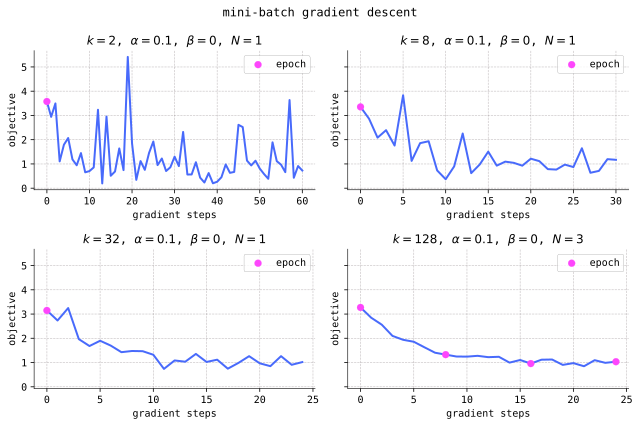

In [22]:
gd_parameters = {'num_epochs': [1, 1, 1, 3],
                 'batch_size': [2, 8, 32, 128],
                 'max_steps': [60, 30, 24, 24]}
alpha = 1e-1
beta = 0
theta0 = torch.tensor([1.5, 1.5])

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 6), sharey=True)

for i, axis in enumerate(axes.flatten()):
    gd_parameters_slice = {key: value[i] for key, value in gd_parameters.items()}
    sgd_output = SGD(**gd_parameters_slice,
                    g=g,
                    X=X,
                    lr=alpha,
                    theta0=theta0,
                    decay_rate=beta,
                    random_state=42)
    
    k = gd_parameters_slice['batch_size']
    N = gd_parameters_slice['num_epochs']
    
    axis.plot(range(len(sgd_output.per_step_objectives)), sgd_output.per_step_objectives)
    axis.scatter(sgd_output.epoch_step_nums, sgd_output.per_step_objectives[sgd_output.epoch_step_nums], color=magenta, s=50, zorder=2, label='epoch')
    axis.set_xlabel('gradient steps')
    axis.set_ylabel('objective')
    axis.set_title(f'$k={k}$, $\\alpha={alpha}$, $\\beta={beta}$, $N={N}$')
    axis.legend()
fig.suptitle('mini-batch gradient descent')
plt.tight_layout()

The runs with batch sizes $k=2, 8, 32$ halt before completing one epoch, while the run with batch size $k=128$ completes three full epochs. Notice that the noise in the plots progressively decreases as the batch size increases. The traces through parameter space look like:

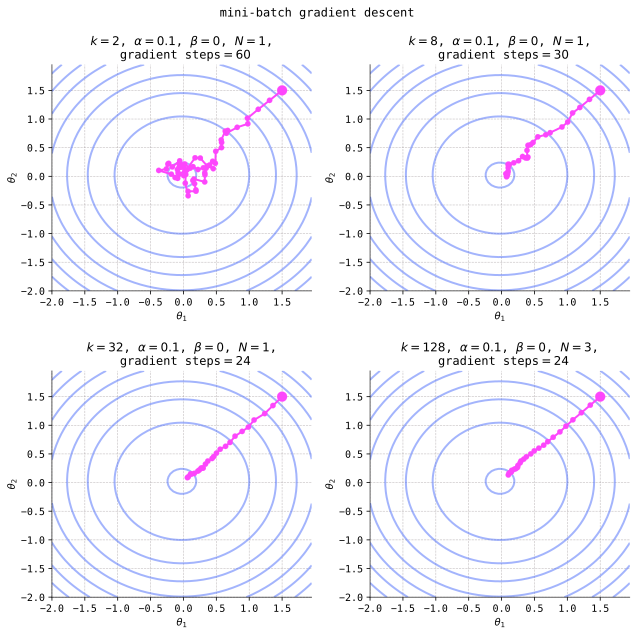

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))

for i, axis in enumerate(axes.flatten()):
    gd_parameters_slice = {key: value[i] for key, value in gd_parameters.items()}
    sgd_output = SGD(**gd_parameters_slice,
                    g=g,
                    X=X,
                    lr=alpha,
                    decay_rate=beta,
                    theta0=theta0,
                    random_state=42)
    
    k = gd_parameters_slice['batch_size']
    max_steps = gd_parameters_slice['max_steps']
    N = gd_parameters_slice['num_epochs']
    
    axis.contour(x, y, z, levels=np.arange(0, 10, 0.5), colors=blue, alpha=0.5)
    axis.plot(sgd_output.thetas[:, 0], sgd_output.thetas[:, 1], color=magenta)
    axis.scatter(sgd_output.thetas[:, 0], sgd_output.thetas[:, 1], s=30, color=magenta, zorder=2)
    axis.scatter(sgd_output.thetas[0, 0], sgd_output.thetas[0, 1], s=100, color=magenta, zorder=2)
    
    axis.set_title(f'$k={k}$, $\\alpha={alpha}$, $\\beta={beta}$, $N={N}$,\n gradient steps$={max_steps}$')
    axis.set_xlabel('$\\theta_1$')
    axis.set_ylabel('$\\theta_2$')
fig.suptitle('mini-batch gradient descent')
plt.tight_layout()

As we mentioned above, it may be helpful to track the mean objective values per epoch to help see the general trend of the objective through the noise. To illustrate this point, let's suppose that we continue our runs of mini-batch gradient descent so that they all complete six epochs. If we plot both the objective per gradient step and the mean objective per epoch, we get the following plots:

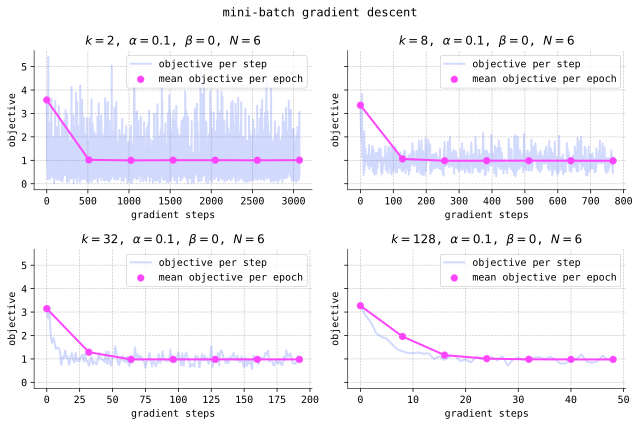

In [24]:
gd_parameters = {'batch_size': [2, 8, 32, 128]}
N = 6
alpha = 1e-1
beta = 0
theta0 = torch.tensor([1.5, 1.5])

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 6), sharey=True)

for i, axis in enumerate(axes.flatten()):
    gd_parameters_slice = {key: value[i] for key, value in gd_parameters.items()}
    sgd_output = SGD(**gd_parameters_slice,
                    g=g,
                    X=X,
                    lr=alpha,
                    theta0=theta0,
                    num_epochs=N,
                    decay_rate=beta,
                    random_state=42)
    
    k = gd_parameters_slice['batch_size']
    
    axis.plot(range(len(sgd_output.per_step_objectives)), sgd_output.per_step_objectives, alpha=0.25, label='objective per step')
    axis.plot(sgd_output.epoch_step_nums, sgd_output.per_epoch_objectives)
    axis.scatter(sgd_output.epoch_step_nums, sgd_output.per_epoch_objectives, s=50, color=magenta, zorder=3, label='mean objective per epoch')
    axis.set_xlabel('gradient steps')
    axis.set_ylabel('objective')
    axis.set_title(f'$k={k}$, $\\alpha={alpha}$, $\\beta={beta}$, $N={N}$')
    axis.legend()
fig.suptitle('mini-batch gradient descent')
plt.tight_layout()

(app-conv-sec)=
## Appendix: Convex functions

To be written!!!

```{prf:definition}
:label: convex-concave-def

We shall say a function $J:\bbr^n \to \bbr$ is _convex_ provided that

$$
J\big((1-t) \ba + t\bb\big) \leq (1-t) J(\ba) + t J(\bb)
$$

for all $\ba,\bb\in \bbr^n$ and all $t\in [0,1]$. If "$\leq$" is replaced with "$<$", then the function is called _strictly convex_; if the inequalities are reversed, we obtain the definitions of _concave_ and _strictly concave_.
```


```{prf:theorem} Main theorem on convex functions (single-variable version)
:label: main-convex-thm

Let $J: \bbr \to \bbr$ be a twice-differentiable function. The following statements are equivalent:

1. The function $J$ is convex.

2. For all numbers $a,b,c$ with $a<b<c$, we have

    $$
    \frac{J(b)-J(a)}{b-a} \leq \frac{J(c)-J(b)}{c-b}.
    $$

3. The graph of $J$ lies above its tangent lines, i.e., for all $\theta,a\in \bbr$, we have

    $$
    J(\theta) \geq J'(a)(\theta-a) + J(a).
    $$

4. The second derivative is nonnegative everywhere, i.e., $J''(\theta)\geq 0$ for all $\theta\in \bbr$.

Moreover, if $\theta^\star$ is a stationary point of $J$ and $J$ is convex, then $\theta^\star$ is a global minimizer.
```

```{prf:proof} 

We shall prove the statements as (1) $\Rightarrow$ (3) $\Rightarrow$ (2) $\Rightarrow$ (1), and then (3) $\Rightarrow$ (4) $\Rightarrow$ (2).

(1) $\Rightarrow$ (3): Suppose that $\theta,a\in \bbr$ and note that

$$
J'(a)(\theta-a) = \lim_{t\to 0} \frac{J\big( a+t(\theta-a) \big) - J(a)}{t}.
$$ (der-almost-eq)

Provided $t\in [0,1]$ we have

$$
J\big( a+t(\theta-a) \big) = J \big( (1-t)a + t\theta\big) \leq (1-t)J(a) + tJ(\theta) = J(a) +t\big(J(\theta) - J(a)\big)
$$

and so

$$
J(\theta) \geq \frac{J\big( a+t(\theta-a) \big) - J(a)}{t} + J(a).
$$

Taking $t\to 0^+$ and using {eq}`der-almost-eq` yields

$$
J(\theta) \geq J'(a) (\theta-a) + J(a),
$$

as desired.

(3) $\Rightarrow$ (2): Letting $a<b<c$, by hypothesis we have

$$
J(a) \geq J'(b)(a-b) + J(b) \quad \text{and} \quad J(c) \geq J'(b)(c-b) + J(b).
$$

Then the inequalities

$$
\frac{J(b)-J(a)}{b-a} \leq J'(b) \leq \frac{J(c)-J(b)}{c-b}
$$

follow immediately, establishing (2).

(2) $\Rightarrow$ (1): Suppose that the inequality

$$
\frac{J(b)-J(a)}{b-a} \leq \frac{J(c)-J(b)}{c-b}
$$ (inc-sec-eq)

holds for all $a<b<c$. Fixing $a$ and $c$ with $a<c$, let $t\in (0,1)$ and set

$$
b = (1-t)a + tc.
$$

Then we have both

$$
t = \frac{b-a}{c-a},
$$ (ratio-t-eq)

and

$$
1-t = \frac{c-b}{c-a}
$$ (second-choice-eq)

But then

$$
\frac{J(b)-J(a)}{t} \leq \frac{J(c)-J(b)}{1-t}
$$

by {eq}`second-choice-eq` and {eq}`inc-sec-eq`. We may rearrange this inequality to obtain

$$
J\big((1-t)a+tc \big) =J(b) \leq (1-t)J(a) + tJ(c),
$$

which is what we wanted to show.

(3) $\Rightarrow$ (4): By the Mean Value Theorem, to prove that $J''(\theta)\geq 0$ for all $\theta$, it will suffice to show that $J'$ is an increasing function. For this, suppose given $a,b\in \bbr$ with $a< b$. By hypothesis, we have both

$$
J(b) \geq J'(a)(b-a) + J(a) \quad \text{and} \quad J(a) \geq J'(b)(a-b) + J(b).
$$

But then

$$
J'(a)(b-a) + J(a) \leq J(b) \leq -J'(b)(a-b) + J(a)
$$

and so $J'(a) \leq J'(b)$.

(4) $\Rightarrow$ (2): Let $a<b<c$. The Mean Value Theorem is then used twice: Once to conclude that $J'$ is an increasing function, and then to show that there are numbers $u\in (a,b)$ and $v\in (b,c)$ such that

$$
J'(u) = \frac{J(b)-J(a)}{b-a} \quad \text{and} \quad J'(v) = \frac{J(c)-J(b)}{b-c}.
$$

But then

$$
\frac{J(b)-J(a)}{b-a} = J'(u) \leq J'(v) = \frac{J(c)-J(b)}{b-c}
$$

since $u<v$ and $J'$ is increasing. Q.E.D.
```

Suppose $g:\bbr \to \bbr$ is a twice-differentiable function, $s,t$ are fixed distinct real numbers, and we define

$$
h:\bbr \to \bbr, \quad h(r) = g\big(r(s-t)+t\big).
$$ (aux-func-eq)

Then

$$
g(s) \geq g'(t) (s-t) + g(t) \quad \Leftrightarrow \quad h(1) \geq h'(0) + h(0)
$$ (aux-tangent-eq)

while

$$
g''(t) \geq 0 \quad \Leftrightarrow \quad h''(0) \geq 0.
$$ (aux-curv-eq)

```{prf:theorem} Main theorem on convex functions (multi-variable version)
:label: main-convex-multi-thm

Blah blah blah, to be written later.
```

```{prf:proof}

Throughout the proof we fix $\btheta,\bv\in \bbr^n$ and we consider the function

$$
g: \bbr \to \bbr, \quad g(t) \def J\big(t \bv + \btheta \big).
$$ (aux-2-eq)

(1) $\Rightarrow$ (2): Supposing that $J$ is convex, the function $g$ is easily seen to be convex. Thus,

$$
J(\bv + \btheta) = g(1) \geq g'(0) + g(0) = \bv^\intercal \nabla J(\btheta) + J(\btheta),
$$

where the second equality follows from {prf:ref}`directional-der-def` and {prf:ref}`directional-der-grad-thm`.

(2) $\Rightarrow$ (3): For real numbers $s,t\in \bbr$, we shall prove

$$
g(s) \geq g'(t)(s-t) + g(t)
$$ (goal-tan-line-eq)

through {eq}`aux-tangent-eq` using the auxiliary function $h$ defined in terms of $g$ via {eq}`aux-func-eq`. But note that

$$
h(1) = J(s\bv + \btheta) \quad \text{and} \quad h(0) = J(t\bv + \btheta)
$$

while

$$
h'(0) = (s-t) \bv^\intercal \nabla J(t\bv + \btheta)
$$

by {prf:ref}`directional-der-grad-thm`. But by hypothesis, we have

$$
J(s\bv + \btheta) \geq (s-t) \bv^\intercal \nabla J(t\bv + \btheta) + J(t\bv + \btheta),
$$

from which {eq}`goal-tan-line-eq` follows. So, since the graph of $g$ lies above its tangent lines, we know what $g''(t)\geq 0$ for all $t$ and, in particular, that $g''(0)\geq 0$. However, from {prf:ref}`directional-der-grad-thm` we get the equality in

$$
\bv^\intercal \nabla^2 J(\btheta) \bv = g''(0)   \geq 0,
$$

which shows that the Hessian matrix $\nabla^2 J(\btheta)$ is positive semidefinite since $\bv$ was chosen arbitrarily.

(3) $\Rightarrow$ (1): We need to prove that

$$
J(t\bv + \btheta) \leq (1-t) J(\btheta) + t J (\bv + \btheta)
$$ (new-goal-eq)

for all $t\in [0,1]$. But note that this is the same inequality as

$$
g(t) \leq (1-t) g(0) + tg(1),
$$

so it will suffice to show that $g$ is convex. But to do this, we shall show $g''(t)\geq 0$ through {eq}`aux-curv-eq` and the auxiliary function $h$. However, we have

$$
h''(0) = (s-t)^2\bv^\intercal \nabla^2 J(t\bv + \btheta)\bv \geq 0
$$

from {prf:ref}`directional-der-grad-thm` and positive semidefiniteness of the Hessian matrix $\nabla^2 J(t\bv + \btheta)$.
```